In [109]:
import os
os.chdir("../src")
import glasgow_behavior
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import ptitprince as pt
import statsmodels.stats.multicomp as mc
from scipy import stats

In [ ]:
#Seperate main GlasgowStudyAll.csv into smaller csvs for analysis
glasgow_behavior.build_csvs("../data/GlasgowStudyAll.csv","../data/subj_status.csv","../csvs")

In [ ]:
#Build input .tsv files for nbridge
qc_fail = ["BKE11","CJY31","CTR13","FCS07","KBL14","MCA13","MMA21","MPA20","RSS08","SPA12","SWE24"]
glasgow_behavior.build_nbridge("../csvs","../data", qc_fail, 'behavior_PassQC_CBS')

In [ ]:
#Plot correlation for n203 model
glasgow_behavior.plot_correlation("../data/nbridge_model1_n203/analysis/figures/NBRIDGE_Glasgow.collaboration_SPIA_NA_CAARMS-BACS-SPIA_n203_prep_AB_BehaviorCorrelation.tsv","../figures/model1_n203_correlation.png")

In [ ]:
#Plot correlation for n187 model
glasgow_behavior.plot_correlation("../data/nbridge_model2_n187/analysis/figures/NBRIDGE_Glasgow.collaboration_SPIA_NoTransition_CAARMS-BACS-SPIA_n187_prep_AB_BehaviorCorrelation.tsv","../figures/model2_n187_correlation.png")

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import ptitprince as pt
import statsmodels.stats.multicomp as mc
from scipy import stats

from matplotlib.patches import Rectangle
from matplotlib.patches import Patch

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels, size):
            self.set_thetagrids(np.degrees(theta), labels, size=size)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def radar_plot(ax, d, title, theta, spoke_labels, thresholds=None, colors=None):
    ax.set_rgrids([])
    ax.set_title(title, size=13, position=(0.5, 1), y=1.15,
                    horizontalalignment='center', verticalalignment='center')
    #Zero line
    ax.plot(theta, np.zeros(len(d)), color='grey', lw=1.8)
    ax.plot(theta, d, color='black', lw=2.5)

    ax.set_varlabels(spoke_labels, 10.5)
    ax.set_ylim(-0.5,0.5)

    a = ax.get_xgridlines()

    if thresholds != None:
        if colors == None:
            print("WARNING: Threshold colors not supplied!")
            return ax
        i = 0
        ti = 0
        t = 0
        for line in a:
            if i > (t-1):
                t = thresholds[ti]
                c = colors[ti]
                ti += 1
            line.set_color(c) 
            i+=1
    return ax

def rain_plot(ax, df, cPalette, order, dx, dy, compute_stats=False, stat_start=[-5,24], stat_gap=1.8):

    ort = "h"; sigma = .5; cut=1.7; move=0.2; linewidth=2; 
    scale=0.85; pointplot=False

    ax=pt.RainCloud(x = dx, y = dy, data = df, palette = cPalette, bw = sigma, cut=cut, order=order, pointplot=pointplot,
                        width_viol = scale, ax = ax, orient = ort, move = move, scale="width", linewidth = linewidth, linecolor="red")

    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.spines[['right', 'top', 'left']].set_visible(False)
    ax.spines.bottom.set(linewidth=6)

    if compute_stats:
        #data without PTT
        stat_df = df[df[dx] != "PTT"]

        #compute stats
        comp1 = mc.MultiComparison(stat_df[dy], stat_df[dx])
        tbl, a1, a2 = comp1.allpairtest(stats.ttest_ind, method= "bonf")

        #ANOVA
        all_data = []
        for group in order:
            all_data.append(stat_df[stat_df[dx] == group][dy].to_numpy())
        f, p = f_oneway(*all_data)

        ax.set_title(f'{dy}\n F={round(f,3)}, p={round(p,3)}')

        #stat bars
        #first row is column names

        loc = {}
        switch = False
        for row in tbl.data[1:]:
            if row[5]:
                g1 = row[0]
                g2 = row[1]
                if g1 == order[-1] or g2 == order[-1]:
                    right = False
                else:
                    right = True
                t = row[2]
                p = row[4]

                g1_i = order.index(g1)
                g2_i = order.index(g2)
                bottom = min(g1_i, g2_i)
                top = max(g1_i, g2_i)

                #length controls line plot x location
                length = abs(g2_i-g1_i)
                gap = stat_gap
                x_dist_iter = length
                x_dist = gap
                br_length =0.75
                

                while x_dist_iter -1 > 0:
                    x_dist_iter -=1
                    x_dist += x_dist_iter + gap

                if right:
                    x_pos = x_dist + stat_start[1] + ((top - length) %length)
                    br_length = -br_length
                    text_offset = 0.8
                else:
                    x_pos = -x_dist + stat_start[0] - ((top - length) %length)
                    text_offset = -2.3
                    
                y_offset = -move
                y_scale = 1
                y_gap = 0.09

                

                #vertical line
                ax.plot([x_pos, x_pos], [y_scale*bottom+y_gap + y_offset, y_scale*top-y_gap + y_offset], lw=1.4, color='black', marker='', zorder=4, clip_on=False)
                y_top = y_scale*top-y_gap + y_offset
                y_bottom = y_scale*bottom+y_gap + y_offset
                sig = "ERROR"
                if p < 0.05:
                    if p < 0.01:
                        if p < 0.001:
                            sig = "***"
                        else:
                            sig = "**"
                    else:
                        sig = "*"

                ax.text(x_pos + text_offset, y_bottom + (y_top-y_bottom)/2, sig,rotation=90, clip_on=False, backgroundcolor='white', zorder=2, color='black', va='center')
                #horizontal bars
                ax.plot([x_pos, x_pos+br_length], [y_scale*top-y_gap + y_offset, y_scale*top-y_gap + y_offset], lw=1.4, color='black', marker='', zorder=4, clip_on=False)
                ax.plot([x_pos, x_pos+br_length], [y_scale*bottom+y_gap + y_offset, y_scale*bottom+y_gap + y_offset], lw=1.4, color='black', marker='', zorder=4, clip_on=False)
    return ax

def correlation_plot(fig, ax, df):
    corr_data = df.to_numpy()
    i = 0
    for x in range(len(corr_data)):
        for y in range(len(corr_data)):
            if y > i:
                corr_data[x][y] = 0
        i += 1

    im = ax.imshow(corr_data, cmap="bwr")
    im.set_clim(-1,1)
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #BACS-CAARMS lines
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[0]+8], [ax.get_ylim()[1]+8, ax.get_ylim()[1]+8], lw=.8, color='black', marker='', zorder=4)
    ax.plot([ax.get_xlim()[0]+8, ax.get_xlim()[0]+8], [ax.get_ylim()[0], ax.get_ylim()[1]+8], lw=.8, color='black', marker='', zorder=4)

    #CAARMS-SPIA lines
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[0]+13], [ax.get_ylim()[1]+13, ax.get_ylim()[1]+13], lw=.8, color='black', marker='', zorder=4)
    ax.plot([ax.get_xlim()[0]+13, ax.get_xlim()[0]+13], [ax.get_ylim()[0], ax.get_ylim()[1]+13], lw=.8, color='black', marker='', zorder=4)

    #Legend bars y axis
    ax.add_patch(Rectangle((ax.get_xlim()[0]-1, ax.get_ylim()[1]), 1,8, facecolor = 'fuchsia', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]-1, ax.get_ylim()[1]+8), 1,5.1, facecolor = 'forestgreen', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]-1, ax.get_ylim()[1]+13.1), 1,14, facecolor = 'orange', clip_on=False))

    #Legend bars x axis
    ax.add_patch(Rectangle((ax.get_xlim()[0], ax.get_ylim()[0]), 8,1, facecolor = '#FF00FF', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]+8, ax.get_ylim()[0]), 5.1,1, facecolor = '#176423', clip_on=False))
    ax.add_patch(Rectangle((ax.get_xlim()[0]+13.1, ax.get_ylim()[0]), 14,1, facecolor = '#ff9402', clip_on=False))

    #Hide the diagonal data
    ax.add_patch(Rectangle((ax.get_xlim()[0], ax.get_ylim()[1]-1.5), 40,1, facecolor = 'white', angle=45, clip_on=False))

    legend_elements = [Patch(facecolor='#FF00FF', label='BACS (1-8)'),
                    Patch(facecolor='#176423', label='CAARMS (9-13)'),
                    Patch(facecolor='#ff9402', label='SPIA (14-27)')]

    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, bbox_to_anchor=(1.05,1), frameon=False)
    plt.colorbar(im, ax=ax, shrink=0.28, aspect=7, pad=-0.15)


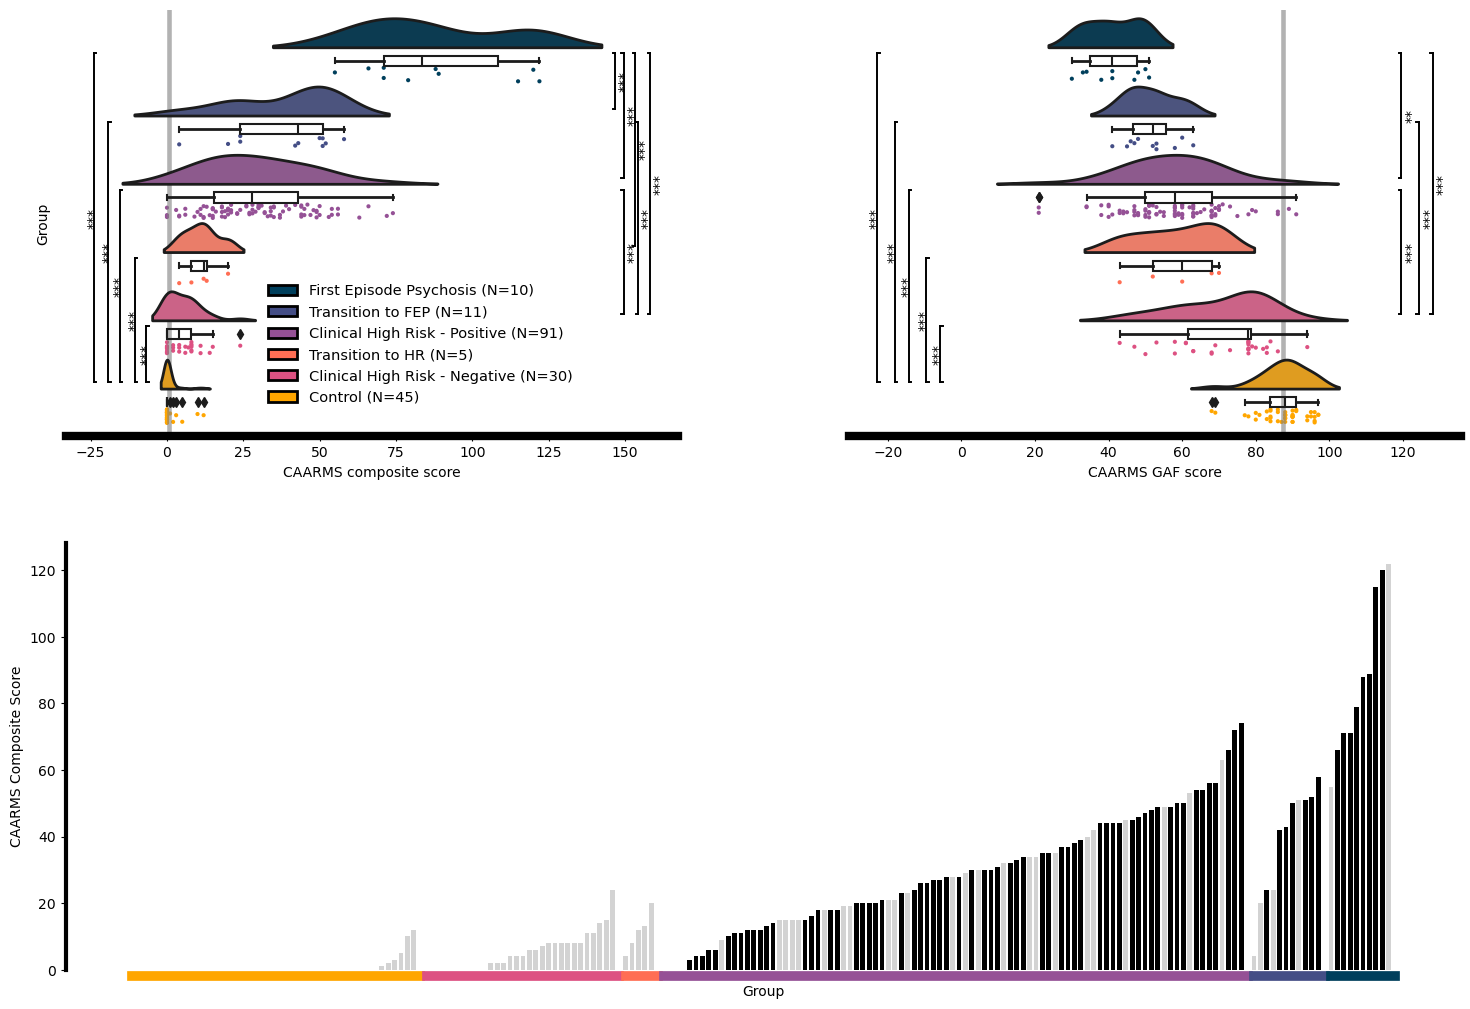

In [283]:
import seaborn as sns

def behavior_plots(behavior):
    fig = plt.figure(figsize=(18,12))
    #heights = [1,0.75,0.4,0.8]
    #widths = [1,1,1.3,1.3,1.3]
    spec = fig.add_gridspec(ncols=2,nrows=2)

    dist_caarms_loc = [spec[0,0],spec[0,1]]
    dist_spia_loc = spec[1,:]
    #group_loc = spec[2,0:4]

    #spec = fig.add_gridspec(ncols=5,nrows=4,height_ratios=heights)
    fig.subplots_adjust(wspace=0.28, hspace=0.25, top=0.85, bottom=0.05)

    order = ['Control', 'Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP', 'First Episode Psychosis']
    order.reverse()
    cDict = {'First Episode Psychosis':"#003f5c", 'Transition to FEP':"#444e86", 'Clinical High Risk - Positive':"#955196",
            'Clinical High Risk - Negative':"#dd5182", 'Transition to HR':"#ff6e54", 'Control':"#ffa600"}
    
    
    
    counts_df = behavior["Group"].value_counts()
    counts = []
    legendLabels = []
    cPalette = []
    for group in order:
        counts.append(counts_df[group])
        legendLabels.append(f'{group} (N={counts_df[group]})')
        cPalette.append(cDict[group])
    counts.reverse()
    #cPalette.reverse()

    #Composite scores calculations
    comp_cols = ['CAARMS_UTC_severity','CAARMS_NBI_severity', 'CAARMS_PA_severity', 'CAARMS_DS_severity']
    behavior['CAARMS_Composite'] = behavior[comp_cols].sum(axis=1)

    #SPIA COGIDS/COPER calculations
    spia_c = behavior.filter(regex="SPIA").columns
    coper_c = spia_c[4:13]
    cogdis_c = spia_c[0:8]
    coper_df = behavior.copy()
    coper_df[coper_df[coper_c] < 3] = 0
    coper_df[coper_df[coper_c] >= 3] = 1
    behavior['COPER_sum'] = coper_df[coper_c].sum(axis=1)
    behavior['COPER'] = behavior['COPER_sum'] > 0
    cogdis_df = behavior.copy()
    cogdis_df[cogdis_df[cogdis_c] < 3] = 0
    cogdis_df[cogdis_df[cogdis_c] >= 3] = 1
    behavior['COGDIS_sum'] = cogdis_df[cogdis_c].sum(axis=1)
    behavior['COGDIS'] = behavior['COGDIS_sum'] > 1
    #behavior['SPIA'] = behavior['COPER'] + behavior['COGDIS']
    #update with actual CHRP diagnoses, FEP have none so must used calculated. Control and CHRN are not diagnosed with either
    behavior = behavior.replace([True,False], ['yes','no'])
    chrp_diag = pd.read_csv('../data/SPIA_diag.tsv',sep='\t').set_index('participant_id')
    behavior = behavior.set_index('participant_id')
    behavior.update(chrp_diag)
    behavior = behavior.reset_index()

    group_list = behavior['Group'].to_list()
    caarms_colors = [cDict[g] for g in group_list]

    ax_compdist = fig.add_subplot(dist_caarms_loc[0])
    ax_compdist = rain_plot(ax_compdist, behavior, cPalette, order, 'Group', 'CAARMS_Composite', True, stat_start=[-5,145])
    ax_compdist.set_xlabel('CAARMS composite score', size=10)
    c_mean = behavior[behavior['Group']=='Control']['CAARMS_Composite'].mean()
    ax_compdist.plot([c_mean,c_mean],[-20,20], zorder=0, color='grey', lw=3.3, alpha=0.6)
    ax_compdist.set_ylabel('Group')
    ax_compdist.set(yticklabels=[])
    ax_compdist.tick_params(left=False)

    ax_gafdist = fig.add_subplot(dist_caarms_loc[1])
    ax_gafdist = rain_plot(ax_gafdist, behavior, cPalette, order, 'Group', 'CAARMS_GAF_Score_baseline_final_score', True, stat_start=[-4,115])
    ax_gafdist.set_xlabel('CAARMS GAF score', size=10)
    c_mean = behavior[behavior['Group']=='Control']['CAARMS_GAF_Score_baseline_final_score'].mean()
    ax_gafdist.plot([c_mean,c_mean],[-20,20], zorder=0, color='grey', lw=3.3, alpha=0.6)
    ax_gafdist.set(yticklabels=[])
    ax_gafdist.tick_params(left=False)

    id_df = pd.read_csv('../csvs/YouR_Study_All_Misc.csv')[['Study_ID','Scan_ID']].rename(columns={'Scan_ID':'participant_id'})
    uhr_df = pd.read_csv('../csvs/UHR_Misc.csv')
    mapper = {0.0:'None',1.0:'CAARMS',2.0:'SPIA',3.0:'Both'}
    uhr_df['UHR_Category'] = uhr_df['UHR_Category'].map(mapper)
    arms_df = pd.read_csv('../csvs/CAARMS_baseline.csv')[['Study_ID', 'CAARMS_group_baseline_final_score']]
    mapper_arms = {'0':'None','1':'Attenuated Psychosis Group','3':'Vulnerability Group','4':'Psychosis Threshold', '5':'Attenuated Psychosis + Vulnerability'}
    arms_df['CAARMS_group_baseline_final_score'] = arms_df['CAARMS_group_baseline_final_score'].map(mapper_arms)#.fillna(arms_df['CAARMS_group_baseline_final_score'])
    merged_df = pd.merge(id_df, uhr_df, how='left', on='Study_ID')
    merged_df = pd.merge(merged_df, arms_df, how='left', on='Study_ID').drop(columns=['Study_ID'])
    behavior = pd.merge(behavior, merged_df, how='left', on='participant_id')
    
    cDictUHR = {'First Episode Psychosis':
                    {'None':"#0096db",
                     'CAARMS':"#0096db",
                     'SPIA':"#003f5c",
                     'Both':"#003f5c"}, 
                'Transition to FEP':
                    {'None':"#a0a8d0",
                     'CAARMS':"#a0a8d0",
                     'SPIA':"#444e86",
                     'Both':"#444e86"},  
                'Clinical High Risk - Positive':
                    {'None':"#d7b6d8",
                     'CAARMS':"#d7b6d8",
                     'SPIA':"#955196",
                     'Both':"#955196"},  
                'Clinical High Risk - Negative':
                    {'None':"#eda3bd",
                     'CAARMS':"#eda3bd",
                     'SPIA':"#dd5182",
                     'Both':"#dd5182"},  
                'Transition to HR':
                    {'None':"#ffb6a8",
                     'CAARMS':"#ffb6a8",
                     'SPIA':"#ff6e54",
                     'Both':"#ff6e54"},  
                'Control':
                    {'None':"#ffd586",
                     'CAARMS':"#ffd586",
                     'SPIA':"#ffa600",
                     'Both':"#ffa600"}  }

    cDictUHR = {'None':'lightgrey','CAARMS':'lightgrey','SPIA':'black','Both':'black'}
    order.reverse()
    ax_group = fig.add_subplot(dist_spia_loc)
    caarms_data = []
    color_data = []
    prev = 0
    for group in order:
        group_df = behavior[behavior['Group'] == group]
        group_df = group_df.sort_values(by=['CAARMS_Composite'], ascending=True)
        caarms_data += group_df['CAARMS_Composite'].to_list()
        #seperator
        caarms_data += [0]*1
        uhr_data = group_df['UHR_Category'].to_list()
        color_data += [cDictUHR[uhr] for uhr in uhr_data]
        color_data += ['white']*1

        ax_group.plot([prev,prev+group_df.shape[0]*2], [-2.,-2.], lw=7, color=cDict[group], clip_on=False)
        prev += group_df.shape[0]*2 + 2
        #print(group_df.shape[0]) counts_df[group]

    x = np.arange(len(caarms_data)*2,step=2)
    ax_group.bar(x, caarms_data, width=1.5, color=color_data)
    ax_group.set(xticklabels=[])
    ax_group.tick_params(bottom=False)
    #ax_group.set(yticklabels=[])
    ax_group.spines[['right', 'top', 'bottom']].set_visible(False)
    #ax_group.spines.bottom.set(linewidth=3)
    ax_group.spines.left.set(linewidth=3)
    ax_group.set_ylim(0)
    ax_group.set_ylabel("CAARMS Composite Score")
    ax_group.set_xlabel("Group")

    

    legend_elements = []
    #legendLabels.reverse()
    for i in range(len(legendLabels)):
        legend_elements.append(Patch(facecolor=cPalette[i], edgecolor='black', linewidth=2, label=legendLabels[i]))

    fig.legend(handles=legend_elements, loc="lower left", bbox_to_anchor=(0.23,0.51), frameon=False, prop={'size': 10.5})
    
    plt.show()
    return

beh_df = pd.read_csv("../data/behavior_PassQC_CBS_ALL.tsv", sep='\t')
behavior_plots(beh_df)

In [143]:
[0]*5

[0, 0, 0, 0, 0]

In [ ]:
behavior = pd.read_csv("../data/behavior_PassQC_CBS_ALL.tsv", sep='\t')
spia_c = behavior.filter(regex="SPIA").columns
coper_c = spia_c[4:13]
cogdis_c = spia_c[0:8]
coper_df = behavior.copy()
coper_df[coper_df[coper_c] < 3] = 0
coper_df[coper_df[coper_c] >= 3] = 1
behavior['COPER_sum'] = coper_df[coper_c].sum(axis=1)
behavior['COPER'] = behavior['COPER_sum'] > 0
cogdis_df = behavior.copy()
cogdis_df[cogdis_df[cogdis_c] < 3] = 0
cogdis_df[cogdis_df[cogdis_c] >= 3] = 1
behavior['COGDIS_sum'] = cogdis_df[cogdis_c].sum(axis=1)
behavior['COGDIS'] = behavior['COGDIS_sum'] > 1

#update with actual CHRP diagnoses, FEP have none so must used calculated. Control and CHRN are not diagnosed with either
behavior = behavior.replace([True,False], ['yes','no'])
chrp_diag = pd.read_csv('../data/SPIA_diag.tsv',sep='\t').set_index('participant_id')
behavior = behavior.set_index('participant_id')
#behavior.update(chrp_diag)
behavior = behavior.reset_index()
behavior['COPER'].value_counts(sort=False)
#behavior[(behavior['Group']=='Clinical High Risk - Negative')]
counts_df = behavior['Group'].value_counts()
counts= []
order = ['Control', 'Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP', 'First Episode Psychosis']
# for group in order:
#     counts.append(counts_df[group])

# for count in counts
#orderIndex = dict(zip(order, range(len(order))))
behavior.sort_values(by="Group", key=lambda column: column.map(lambda e: order.index(e)), inplace=True)
behavior
# # behavior[(behavior['Group']=='Clinical High Risk - Negative') & (behavior['COGDIS']=='yes')]
# comp_cols = ['CAARMS_UTC_severity','CAARMS_NBI_severity', 'CAARMS_PA_severity', 'CAARMS_DS_severity']
# behavior['CAARMS_Composite'] = behavior[comp_cols].sum(axis=1)
# behavior = behavior.sort_values(by=['CAARMS_Composite'])
# caarms_comp = behavior['CAARMS_Composite'].to_numpy()
# plt.bar(np.arange(len(caarms_comp)),height=caarms_comp.tolist(),width=1)

In [ ]:
caarms_comp

In [ ]:
beh_df = pd.read_csv("../data/behavior_PassQC_CBS_ALL.tsv", sep='\t')
spia_c = beh_df.filter(regex="SPIA").columns
coper_c = spia_c[4:13]
cogdis_c = spia_c[0:8]

coper_df = beh_df.copy()
coper_df[coper_df[coper_c] < 3] = 0
coper_df[coper_df[coper_c] >= 3] = 1

beh_df['COPER_sum'] = coper_df[coper_c].sum(axis=1)
beh_df['COPER_diagnosis'] = beh_df['COPER_sum'] > 0

cogdis_df = beh_df.copy()
cogdis_df[cogdis_df[cogdis_c] < 3] = 0
cogdis_df[cogdis_df[cogdis_c] >= 3] = 1

beh_df['COGDIS_sum'] = cogdis_df[cogdis_c].sum(axis=1)
beh_df['COGDIS_diagnosis'] = beh_df['COGDIS_sum'] > 1
beh_df[(beh_df['Group']=='Clinical High Risk - Negative')]
# beh_count_df = pd.DataFrame()
# order = ['Control', 'Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP', 'First Episode Psychosis']
# beh_count_df['Group'] = order

# def sort_counts(counts):
#     sorted = []
#     for group in order:
#         if group in counts.keys():
#             sorted.append(counts[group])
#         else:
#             sorted.append(0)
#     return sorted

# beh_count_df['Total'] = sort_counts(beh_df['Group'].value_counts())
# beh_count_df['COGDIS'] = sort_counts(beh_df[beh_df['COGDIS_diagnosis'] == True]['Group'].value_counts())
# beh_count_df['COPER'] = sort_counts(beh_df[beh_df['COPER_diagnosis'] == True]['Group'].value_counts())
# beh_count_df['COGDIS only'] = sort_counts(beh_df[(beh_df['COGDIS_diagnosis'] == True) & (beh_df['COPER_diagnosis'] == False)]['Group'].value_counts())
# beh_count_df['COPER only'] = sort_counts(beh_df[(beh_df['COGDIS_diagnosis'] == False) & (beh_df['COPER_diagnosis'] == True)]['Group'].value_counts())
# beh_count_df['COGDIS and COPER'] = sort_counts(beh_df[(beh_df['COGDIS_diagnosis'] == True) & (beh_df['COPER_diagnosis'] == True)]['Group'].value_counts())
# beh_count_df['COGDIS or COPER'] = sort_counts(beh_df[(beh_df['COGDIS_diagnosis'] == True) | (beh_df['COPER_diagnosis'] == True)]['Group'].value_counts())
# beh_count_df['neither COGDIS or COPER'] = sort_counts(beh_df[(beh_df['COGDIS_diagnosis'] == False) & (beh_df['COPER_diagnosis'] == False)]['Group'].value_counts())


# beh_df[(beh_df['COGDIS_diagnosis'] == False) & (beh_df['COPER_diagnosis'] == True)]['Group'].value_counts()['First Episode Psychosis']

# beh_count_df

In [ ]:
beh_df[beh_df['Group'] == 'Clinical High Risk - Negative']

In [ ]:
# behavior = pd.read_csv("../data/behavior_PassQC_CBS_ALL.tsv", sep='\t')
# spia_c = behavior.filter(regex="SPIA").columns
# coper_c = spia_c[4:13]
# cogdis_c = spia_c[0:8]

# coper_df = behavior.copy()
# coper_df[coper_df[coper_c] < 3] = 0
# coper_df[coper_df[coper_c] >= 3] = 1

# behavior['COPER_sum'] = behavior[coper_c].sum(axis=1)
# behavior['COPER_diagnosis'] = behavior['COPER_sum'] > 0

# cogdis_df = behavior.copy()
# cogdis_df[cogdis_df[cogdis_c] < 3] = 0
# cogdis_df[cogdis_df[cogdis_c] >= 3] = 1

# behavior['COGDIS_sum'] = cogdis_df[cogdis_c].sum(axis=1)
# behavior['COGDIS_diagnosis'] = behavior['COGDIS_sum'] > 1

behavior = pd.read_csv("../data/behavior_PassQC_CBS_ALL.tsv", sep='\t')
spia_c = behavior.filter(regex="SPIA").columns
coper_c = spia_c[4:13]
cogdis_c = spia_c[0:8]

coper_df = behavior.copy()
coper_df[coper_df[coper_c] < 3] = 0
coper_df[coper_df[coper_c] >= 3] = 1

behavior['COPER_sum'] = coper_df[coper_c].sum(axis=1)
behavior['COPER_diagnosis'] = behavior['COPER_sum'] > 0

cogdis_df = behavior.copy()
cogdis_df[cogdis_df[cogdis_c] < 3] = 0
cogdis_df[cogdis_df[cogdis_c] >= 3] = 1

behavior['COGDIS_sum'] = cogdis_df[cogdis_c].sum(axis=1)
behavior['COGDIS_diagnosis'] = behavior['COGDIS_sum'] > 1

#update with actual CHRP diagnoses, FEP have none so must used calculated. Control and CHRN are not diagnosed with either
# behavior = behavior.replace([True,False], ['yes','no'])
# chrp_diag = pd.read_csv('../data/SPIA_diag.tsv',sep='\t').set_index('participant_id')
# behavior = behavior.set_index('participant_id')
# #behavior.update(chrp_diag)
# behavior = behavior.reset_index()
# behavior['COPER'].value_counts()
behavior[(behavior['Group']=='Clinical High Risk - Negative')]

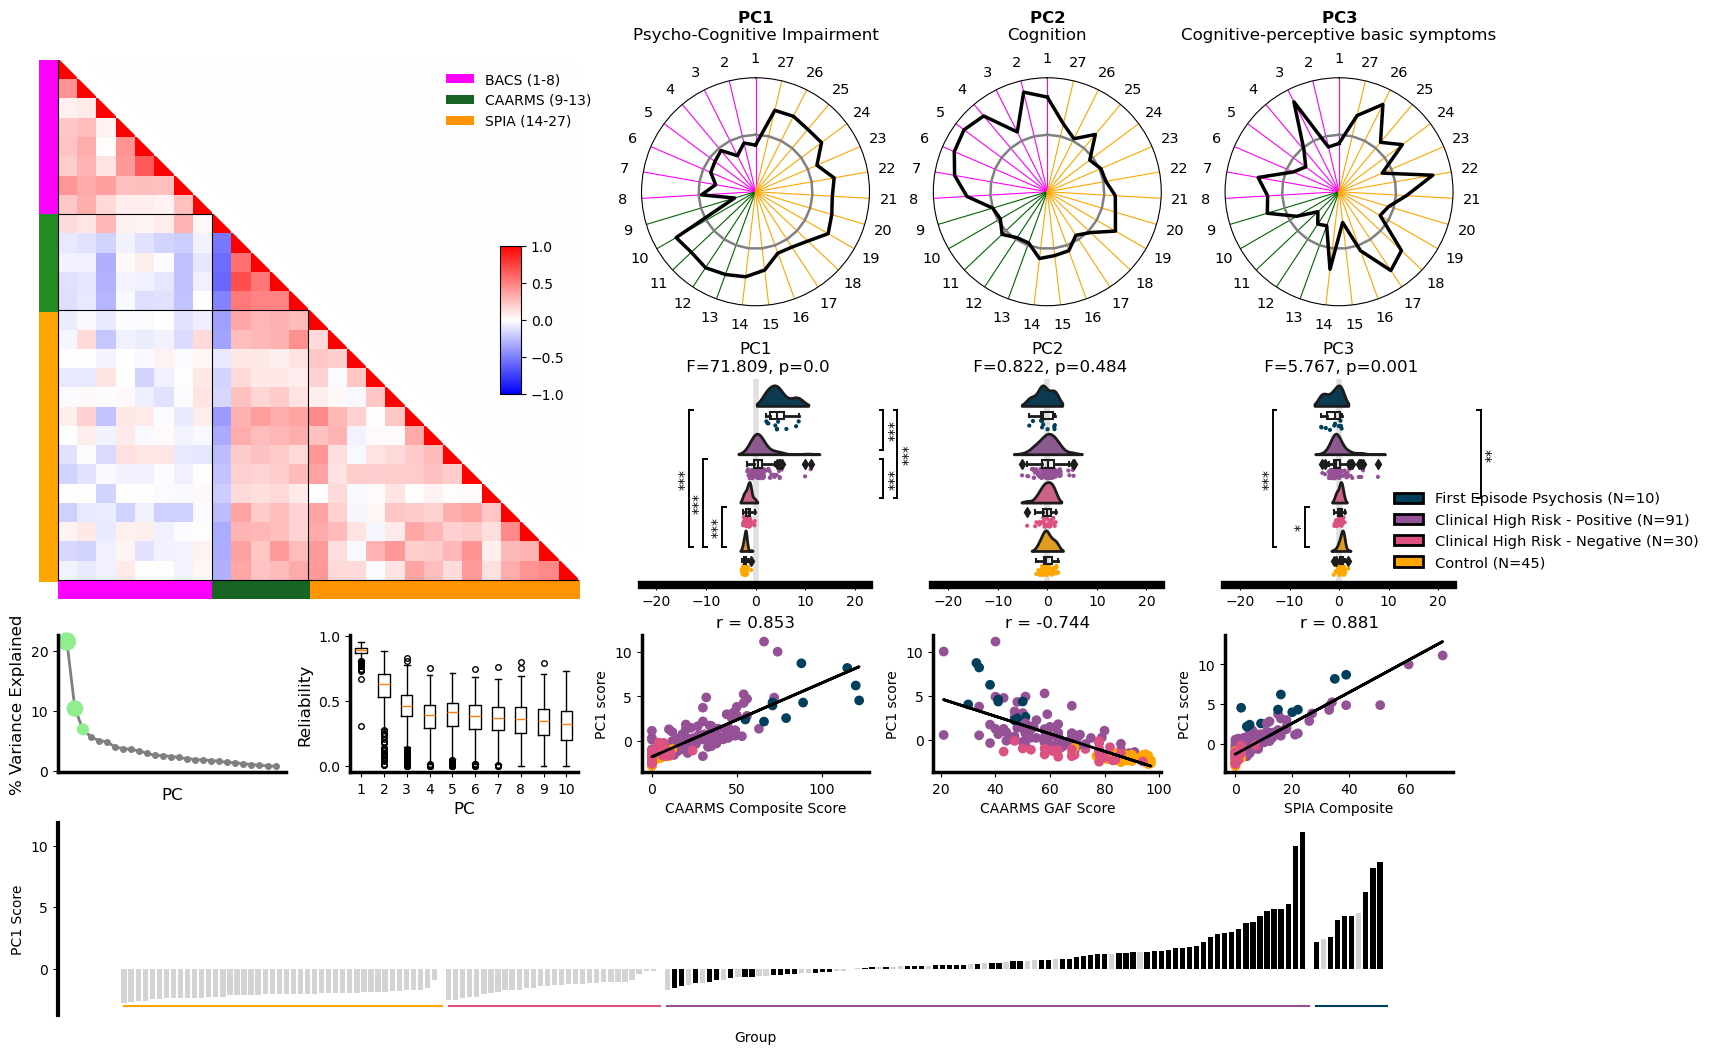

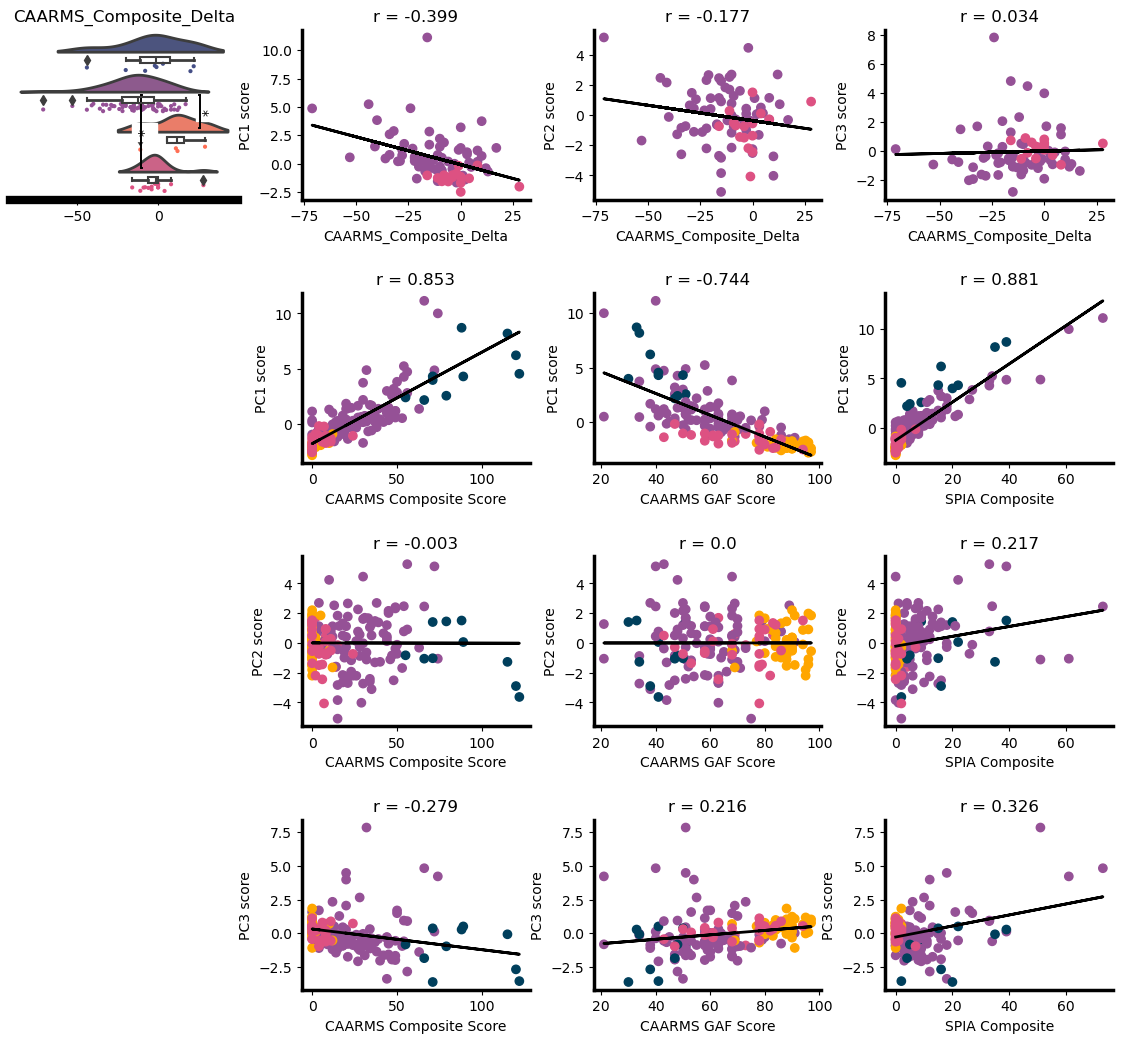

In [111]:
#WITHOUT PTT
from matplotlib import gridspec
from matplotlib.patches import Wedge
import glob

def create_plots(scores, loadings, corr_df, scree_df, df_box, caarms_df, order, thresholds=[8,13,27], pcs=3):

    fig = plt.figure(figsize=(18,12))
    heights = [1,0.75,0.5, 0.7]
    widths = [1,1,1.3,1.3,1.3]
    #spec = fig.add_gridspec(ncols=5,nrows=3)
    spec = fig.add_gridspec(ncols=5,nrows=4,height_ratios=heights)
    fig.subplots_adjust(wspace=0.28, hspace=0.25, top=0.85, bottom=0.05)

    A_loc = spec[0:2,0:2]
    B_loc = [spec[0,2],spec[0,3],spec[0,4]]
    C_loc = spec[2,0]
    D_loc = spec[2,1]
    E_loc = [spec[1,2],spec[1,3],spec[1,4]]
    PC_caarms_loc = [spec[2,2],spec[2,3],spec[2,4]]
    PC_spia = spec[3,:]

    
    colors=['magenta','darkgreen','orange']
    #thresholds 
    pc_descrips = ['Psycho-Cognitive Impairment', 'Cognition', 'Cognitive-perceptive basic symptoms']
    
    cDict = {'First Episode Psychosis':"#003f5c", 'Transition to FEP':"#444e86", 'Clinical High Risk - Positive':"#955196",
            'Clinical High Risk - Negative':"#dd5182", 'Transition to HR':"#ff6e54", 'Control':"#ffa600", 'None':"#eeee0e",
                 'Transition to AP':"#ff9e30",
                 'Transition to None':"#ff5571",
                 'Remain AP':"#c040a0",
                 'AP to Psychosis Threshold':"#3b48a5"}
    
    #Dropping PTT (all group)
    scores = scores[scores['Group'] != "PTT"]
    counts_df = scores["Group"].value_counts()
    counts = []
    legendLabels = []
    cPalette = []
    for group in order:
        counts.append(counts_df[group])
        legendLabels.append(f'{group} (N={counts_df[group]})')
        cPalette.append(cDict[group])
    counts.reverse()
    
    l_data = loadings.to_numpy()
    n_vars = l_data.shape[1]

    spoke_labels = np.arange(1,n_vars+1)
    theta = radar_factory(n_vars, frame='circle')

    r_ranges = [(-10,25), (-17.5,17.5), (-20,15)]

    for pc in range(pcs):
        #Radar plot
        ax_radar = fig.add_subplot(B_loc[pc],projection='radar')
        d = l_data[pc]
        title=fr"$\bf{{PC{pc+1}}}$" "\n" f"{pc_descrips[pc]}"
        ax_radar = radar_plot(ax_radar, d, title, theta, spoke_labels, thresholds, colors)
        ax_radar.set_title(title,x=0.5,y=1.13)  
        #ax_radar.plot([0,0],[-50,50], color='red', lw=5, zorder=10)

        #Raincloud plot
        ax_rain = fig.add_subplot(E_loc[pc])
        ax_rain.plot([0,0],[-20,20], zorder=0, color='lightgrey', lw=4, alpha=0.7)
        ax_rain = rain_plot(ax_rain, scores, cPalette, order, 'Group', f'PC{pc+1}', True)
        ax_rain.set_xlim((-23,23))
        #ax_rain.set_title(f"PC{pc+1} score", size=12)
        ax_rain.set(yticklabels=[])
        ax_rain.tick_params(left=False)

    legend_elements = []
    #legendLabels.reverse()
    for i in range(len(legendLabels)):
        legend_elements.append(Patch(facecolor=cPalette[i], edgecolor='black', linewidth=2, label=legendLabels[i]))

    fig.legend(handles=legend_elements, loc="lower left", bbox_to_anchor=(0.86,0.41), frameon=False, prop={'size': 10.5})

    #Correlation plot
    ax_corr = fig.add_subplot(A_loc)
    
    ax_corr = correlation_plot(fig, ax_corr, corr_df)

    #scree plot
    
    scree_data = scree_df.to_numpy()*100 #convert to percentage
    ax_scree = fig.add_subplot(C_loc)
    #plot all PCs
    ax_scree.plot(scree_data[:,0], scree_data[:,1],'o-', markersize=4, color='grey', linewidth=2, zorder=0)
    #Significant PCs (top 3)
    ax_scree.scatter(scree_data[:3,0], scree_data[:3,1], [150,120,60], color='lightgreen', clip_on=False)
    #pie chart with proportion of explained variance
    ex_var = scree_data[:3,1].sum()

    ax_scree.set_ylabel("")
    ax_scree.set_xlabel("")
    ax_scree.spines[['right', 'top']].set_visible(False)
    ax_scree.spines.bottom.set(linewidth=2.5)
    ax_scree.spines.left.set(linewidth=2.5)
    ax_scree.set_xlabel("PC", size=12)
    ax_scree.set_ylabel("% Variance Explained", size=12)
    ax_scree.set(xticklabels=[])
    ax_scree.tick_params(bottom=False)
    ax_scree.set_xlim(left=-10)
    
    box_data = []
    labels = []
    for pc in df_box['PC'].unique():
        box_data.append(df_box['R'][df_box['PC'] == pc].to_list())
        labels.append(pc)
    ax_box = fig.add_subplot(D_loc)
    ax_box.boxplot(box_data, flierprops={'markersize':4})
    ax_box.spines[['right', 'top']].set_visible(False)
    ax_box.spines.bottom.set(linewidth=2.5)
    ax_box.spines.left.set(linewidth=2.5)
    ax_box.set_xlabel("PC", size=12)
    ax_box.set_ylabel("Reliability", size=12)

    comp_cols = ['CAARMS_UTC_severity','CAARMS_NBI_severity', 'CAARMS_PA_severity', 'CAARMS_DS_severity']
    caarms_df['CAARMS Composite'] = caarms_df[comp_cols].sum(axis=1).to_numpy()
    caarms_GAF = caarms_df['CAARMS_GAF_Score_baseline_final_score'].to_numpy()
    
    scores = pd.merge(scores, caarms_df, how='left', on='participant_id', suffixes=('', '_y'))
    groups = scores['Group'].to_list()
    caarms_colors = [cDict[g] for g in groups]

    ax_pc_caarms = fig.add_subplot(PC_caarms_loc[0])
    ax_pc_caarms.scatter(x=scores['CAARMS Composite'], y=scores[f'PC1'], c=caarms_colors)
    #Regression line
    m, b = np.polyfit(scores['CAARMS Composite'], scores[f'PC1'], 1)
    ax_pc_caarms.plot(scores['CAARMS Composite'], m*scores['CAARMS Composite']+b, c='black', lw=2.0)
    r = round(np.corrcoef(scores['CAARMS Composite'], scores[f'PC1'])[1,0],3)
    ax_pc_caarms.set_title(f'r = {r}')

    ax_pc_caarms.spines[['right', 'top']].set_visible(False)
    ax_pc_caarms.spines.bottom.set(linewidth=2.5)
    ax_pc_caarms.spines.left.set(linewidth=2.5)
    ax_pc_caarms.set_xlabel('CAARMS Composite Score')
    ax_pc_caarms.set_ylabel(f'PC1 score')
    ax_pc_caarms = fig.add_subplot(PC_caarms_loc[1])
    ax_pc_caarms.scatter(x=scores['CAARMS_GAF_Score_baseline_final_score'], y=scores[f'PC1'], c=caarms_colors)
    #Regression line
    m, b = np.polyfit(scores['CAARMS_GAF_Score_baseline_final_score'], scores[f'PC1'], 1)
    ax_pc_caarms.plot(scores['CAARMS_GAF_Score_baseline_final_score'], m*scores['CAARMS_GAF_Score_baseline_final_score']+b, c='black', lw=2.0)
    r = round(np.corrcoef(scores['CAARMS_GAF_Score_baseline_final_score'], scores[f'PC1'])[1,0],3)
    ax_pc_caarms.set_title(f'r = {r}')

    ax_pc_caarms.spines[['right', 'top']].set_visible(False)
    ax_pc_caarms.spines.bottom.set(linewidth=2.5)
    ax_pc_caarms.spines.left.set(linewidth=2.5)
    ax_pc_caarms.set_xlabel('CAARMS GAF Score')
    ax_pc_caarms.set_ylabel(f'PC1 score')

    scores['SPIA Composite'] = scores.filter(regex='SPIA').sum(axis=1)
    spia_comp = scores['SPIA Composite'].to_numpy()

    ax_spia = fig.add_subplot(PC_caarms_loc[2])
    ax_spia.scatter(x=spia_comp, y=scores[f'PC1'], c=caarms_colors)
    m, b = np.polyfit(spia_comp, scores[f'PC1'], 1)
    ax_spia.plot(spia_comp, m*spia_comp+b, c='black', lw=2.0)

    r = round(np.corrcoef(spia_comp, scores[f'PC1'])[1,0],3)
    ax_spia.set_title(f'r = {r}')

    ax_spia.spines[['right', 'top']].set_visible(False)
    ax_spia.spines.bottom.set(linewidth=2.5)
    ax_spia.spines.left.set(linewidth=2.5)
    ax_spia.set_xlabel('SPIA Composite')
    ax_spia.set_ylabel(f'PC1 score')

    id_df = pd.read_csv('../csvs/YouR_Study_All_Misc.csv')[['Study_ID','Scan_ID']].rename(columns={'Scan_ID':'participant_id'})
    uhr_df = pd.read_csv('../csvs/UHR_Misc.csv')
    mapper = {0.0:'None',1.0:'CAARMS',2.0:'SPIA',3.0:'Both'}
    uhr_df['UHR_Category'] = uhr_df['UHR_Category'].map(mapper)
    arms_df = pd.read_csv('../csvs/CAARMS_baseline.csv')[['Study_ID', 'CAARMS_group_baseline_final_score']]
    mapper_arms = {'0':'None','1':'Attenuated Psychosis Group','3':'Vulnerability Group','4':'Psychosis Threshold', '5':'Attenuated Psychosis + Vulnerability'}
    arms_df['CAARMS_group_baseline_final_score'] = arms_df['CAARMS_group_baseline_final_score'].map(mapper_arms)#.fillna(arms_df['CAARMS_group_baseline_final_score'])
    merged_df = pd.merge(id_df, uhr_df, how='left', on='Study_ID')
    merged_df = pd.merge(merged_df, arms_df, how='left', on='Study_ID').drop(columns=['Study_ID'])
    #print(scores.columns)
    scores = pd.merge(scores, merged_df, how='left', on='participant_id')
    
    cDictUHR = {'None':'lightgrey','CAARMS':'lightgrey','SPIA':'black','Both':'black'}
    order.reverse()
    ax_group = fig.add_subplot(PC_spia)
    pc1_data = []
    color_data = []
    prev=0
    for group in order:
        group_df = scores[scores['Group'] == group]
        group_df = group_df.sort_values(by=['PC1'], ascending=True)
        pc1_data += group_df['PC1'].to_list()
        #seperator
        pc1_data += [0]*1
        uhr_data = group_df['UHR_Category'].to_list()
        color_data += [cDictUHR[uhr] for uhr in uhr_data]
        color_data += ['white']*1
        #print(group_df.shape[0])
        ax_group.plot([prev,prev+group_df.shape[0]*2], [-3,-3], lw=1.5, color=cDict[group])
        prev += group_df.shape[0]*2 + 2

    x = np.arange(len(pc1_data)*2,step=2)
    ax_group.bar(x, pc1_data, width=1.5, color=color_data)
    ax_group.set(xticklabels=[])
    ax_group.tick_params(bottom=False)
    #ax_group.set(yticklabels=[])
    ax_group.spines[['right', 'top', 'bottom']].set_visible(False)
    #ax_group.spines.bottom.set(linewidth=3)
    ax_group.spines.left.set(linewidth=3)
    ax_group.set_ylabel("PC1 Score")
    ax_group.set_xlabel("Group")




    

    # ax_comp = fig.add_subplot(comp_loc)
    # ax_comp.scatter(x=caarms_comp, y=caarms_GAF, s=10, c=caarms_colors)


    plt.show()

def supplement_plots(scores, behavior, delta_df=False):
    fig = plt.figure(figsize=(18,12))
    spec = fig.add_gridspec(ncols=5,nrows=4)
    fig.subplots_adjust(wspace=0.28, hspace=0.55, top=0.85, bottom=0.05)

    delta_loc = [spec[0,0],spec[0,1],spec[0,2],spec[0,3],spec[0,4]]

    PC_caarms_loc = [[spec[1,1],spec[1,2],spec[1,3],spec[1,4]],
                     [spec[2,1],spec[2,2],spec[2,3],spec[2,4]],
                     [spec[3,1],spec[3,2],spec[3,3],spec[3,4]]]

    cDict = {'First Episode Psychosis':"#003f5c", 'Transition to FEP':"#444e86", 'Clinical High Risk - Positive':"#955196",
        'Clinical High Risk - Negative':"#dd5182", 'Transition to HR':"#ff6e54", 'Control':"#ffa600"}

    delta_order = ['Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP']
    delta_order.reverse()
    #Dropping PTT (all group)
    scores = scores[scores['Group'] != "PTT"]
    delta_counts_df = delta_df["Group"].value_counts()
    delta_counts = []
    delta_legendLabels = []
    delta_cPalette = []
    for group in delta_order:
        #delta_counts.append(delta_counts_df[group])
        delta_legendLabels.append(f'{group} (N={delta_counts_df[group]})')
        delta_cPalette.append(cDict[group])
    #delta_counts.reverse()
    

    if not isinstance(delta_df, bool):
        delta_df = pd.merge(delta_df, scores[['participant_id', 'PC1', 'PC2', 'PC3']], how='left', on='participant_id')
        
        ax_rain = fig.add_subplot(delta_loc[0])
        #ax_rain.plot([0,0],[-20,20], zorder=0, color='lightgrey', lw=4, alpha=0.7)
        ax_rain = rain_plot(ax_rain, delta_df, delta_cPalette, delta_order, 'Group', f'CAARMS_Composite_Delta', True)
        #ax_rain.set_xlim((-23,23))
        ax_rain.set_title(f"CAARMS_Composite_Delta", size=12)
        ax_rain.set(yticklabels=[])
        ax_rain.tick_params(left=False)

        delta_df = delta_df[delta_df['PC1'].notna()]

        d_groups = delta_df['Group'].to_list()
        delta_colors = [cDict[g] for g in d_groups]

        ax_delta = fig.add_subplot(delta_loc[1])
        ax_delta.scatter(x=delta_df['CAARMS_Composite_Delta'], y=delta_df[f'PC1'], c=delta_colors)
        ax_delta.spines[['right', 'top']].set_visible(False)
        ax_delta.spines.bottom.set(linewidth=2.5)
        ax_delta.spines.left.set(linewidth=2.5)
        ax_delta.set_xlabel('CAARMS_Composite_Delta')
        ax_delta.set_ylabel(f'PC1 score')
        m, b = np.polyfit(delta_df['CAARMS_Composite_Delta'], delta_df[f'PC1'], 1)
        ax_delta.plot(delta_df['CAARMS_Composite_Delta'], m*delta_df['CAARMS_Composite_Delta']+b, c='black', lw=2.0)
        r = round(np.corrcoef(delta_df['CAARMS_Composite_Delta'], delta_df[f'PC1'])[1,0],3)
        ax_delta.set_title(f'r = {r}')

        ax_delta = fig.add_subplot(delta_loc[2])
        ax_delta.scatter(x=delta_df['CAARMS_Composite_Delta'], y=delta_df[f'PC2'], c=delta_colors)
        ax_delta.spines[['right', 'top']].set_visible(False)
        ax_delta.spines.bottom.set(linewidth=2.5)
        ax_delta.spines.left.set(linewidth=2.5)
        ax_delta.set_xlabel('CAARMS_Composite_Delta')
        ax_delta.set_ylabel(f'PC2 score')
        m, b = np.polyfit(delta_df['CAARMS_Composite_Delta'], delta_df[f'PC2'], 1)
        ax_delta.plot(delta_df['CAARMS_Composite_Delta'], m*delta_df['CAARMS_Composite_Delta']+b, c='black', lw=2.0)
        r = round(np.corrcoef(delta_df['CAARMS_Composite_Delta'], delta_df[f'PC2'])[1,0],3)
        ax_delta.set_title(f'r = {r}')

        ax_delta = fig.add_subplot(delta_loc[3])
        ax_delta.scatter(x=delta_df['CAARMS_Composite_Delta'], y=delta_df[f'PC3'], c=delta_colors)
        ax_delta.spines[['right', 'top']].set_visible(False)
        ax_delta.spines.bottom.set(linewidth=2.5)
        ax_delta.spines.left.set(linewidth=2.5)
        ax_delta.set_xlabel('CAARMS_Composite_Delta')
        ax_delta.set_ylabel(f'PC3 score')
        m, b = np.polyfit(delta_df['CAARMS_Composite_Delta'], delta_df[f'PC3'], 1)
        ax_delta.plot(delta_df['CAARMS_Composite_Delta'], m*delta_df['CAARMS_Composite_Delta']+b, c='black', lw=2.0)
        r = round(np.corrcoef(delta_df['CAARMS_Composite_Delta'], delta_df[f'PC3'])[1,0],3)
        ax_delta.set_title(f'r = {r}')

    c_comp_cols = ['CAARMS_UTC_severity','CAARMS_NBI_severity', 'CAARMS_PA_severity', 'CAARMS_DS_severity']
    scores['CAARMS Composite'] = behavior[c_comp_cols].sum(axis=1).to_numpy()
    scores['CAARMS_GAF_Score_baseline_final_score'] = behavior['CAARMS_GAF_Score_baseline_final_score']
    groups = scores['Group'].to_list()
    caarms_colors = [cDict[g] for g in groups]

    for pc in range(3):
        ax_pc_caarms = fig.add_subplot(PC_caarms_loc[pc][0])
        ax_pc_caarms.scatter(x=scores['CAARMS Composite'], y=scores[f'PC{pc+1}'], c=caarms_colors)
        #Regression line
        m, b = np.polyfit(scores['CAARMS Composite'], scores[f'PC{pc+1}'], 1)
        ax_pc_caarms.plot(scores['CAARMS Composite'], m*scores['CAARMS Composite']+b, c='black', lw=2.0)
        r = round(np.corrcoef(scores['CAARMS Composite'], scores[f'PC{pc+1}'])[1,0],3)
        ax_pc_caarms.set_title(f'r = {r}')
        ax_pc_caarms.spines[['right', 'top']].set_visible(False)
        ax_pc_caarms.spines.bottom.set(linewidth=2.5)
        ax_pc_caarms.spines.left.set(linewidth=2.5)
        ax_pc_caarms.set_xlabel('CAARMS Composite Score')
        ax_pc_caarms.set_ylabel(f'PC{pc+1} score')

        ax_pc_caarms = fig.add_subplot(PC_caarms_loc[pc][1])
        ax_pc_caarms.scatter(x=scores['CAARMS_GAF_Score_baseline_final_score'], y=scores[f'PC{pc+1}'], c=caarms_colors)
        #Regression line
        m, b = np.polyfit(scores['CAARMS_GAF_Score_baseline_final_score'], scores[f'PC{pc+1}'], 1)
        ax_pc_caarms.plot(scores['CAARMS_GAF_Score_baseline_final_score'], m*scores['CAARMS_GAF_Score_baseline_final_score']+b, c='black', lw=2.0)
        r = round(np.corrcoef(scores['CAARMS_GAF_Score_baseline_final_score'], scores[f'PC{pc+1}'])[1,0],3)
        ax_pc_caarms.set_title(f'r = {r}')
        ax_pc_caarms.spines[['right', 'top']].set_visible(False)
        ax_pc_caarms.spines.bottom.set(linewidth=2.5)
        ax_pc_caarms.spines.left.set(linewidth=2.5)
        ax_pc_caarms.set_xlabel('CAARMS GAF Score')
        ax_pc_caarms.set_ylabel(f'PC{pc+1} score')

        scores['SPIA Composite'] = behavior.filter(regex='SPIA').sum(axis=1)
        spia_comp = scores['SPIA Composite'].to_numpy()

        ax_spia = fig.add_subplot(PC_caarms_loc[pc][2])
        ax_spia.scatter(x=spia_comp, y=scores[f'PC{pc+1}'], c=caarms_colors)
        m, b = np.polyfit(spia_comp, scores[f'PC{pc+1}'], 1)
        ax_spia.plot(spia_comp, m*spia_comp+b, c='black', lw=2.0)

        r = round(np.corrcoef(spia_comp, scores[f'PC{pc+1}'])[1,0],3)
        ax_spia.set_title(f'r = {r}')

        ax_spia.spines[['right', 'top']].set_visible(False)
        ax_spia.spines.bottom.set(linewidth=2.5)
        ax_spia.spines.left.set(linewidth=2.5)
        ax_spia.set_xlabel('SPIA Composite')
        ax_spia.set_ylabel(f'PC{pc+1} score')

    return

folder="/Users/sab322/glasgow/presentation/data"
prefix="NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_"
scores = pd.read_csv(f'{folder}/{prefix}BehaviorPCAScores.tsv', sep='\t')
loadings = pd.read_csv(f'{folder}/{prefix}BehaviorPCALoadings.tsv',sep='\t').drop(columns=['Unnamed: 0'])
loadings = loadings*-1
scores[['PC1','PC2','PC3']] = scores[['PC1','PC2','PC3']] *-1
corr_df = pd.read_csv(f'{folder}/{prefix}prep_AB_BehaviorCorrelation.tsv', sep='\t', header=None)
scree_df = pd.read_csv(f'{folder}/{prefix}prep_CA_BehaviorPCAScreeplot.tsv', sep='\t', header=None)
df_box = pd.read_csv('../data/boxplot_data_n187.csv')
caarms_df = pd.read_csv(f'{folder}/behavior_PassQC_CBS_NT.tsv', sep='\t')
order = ['Control', 'Clinical High Risk - Negative', 'Clinical High Risk - Positive', 'First Episode Psychosis']
order.reverse()
create_plots(scores,loadings, corr_df, scree_df, df_box, caarms_df, order)

delta_df = pd.read_csv('/Users/sab322/glasgow/presentation/data/behavior_followup_ALL.tsv', sep='\t')
supplement_plots(scores, caarms_df, delta_df)

PassQC analysis without Transition groups

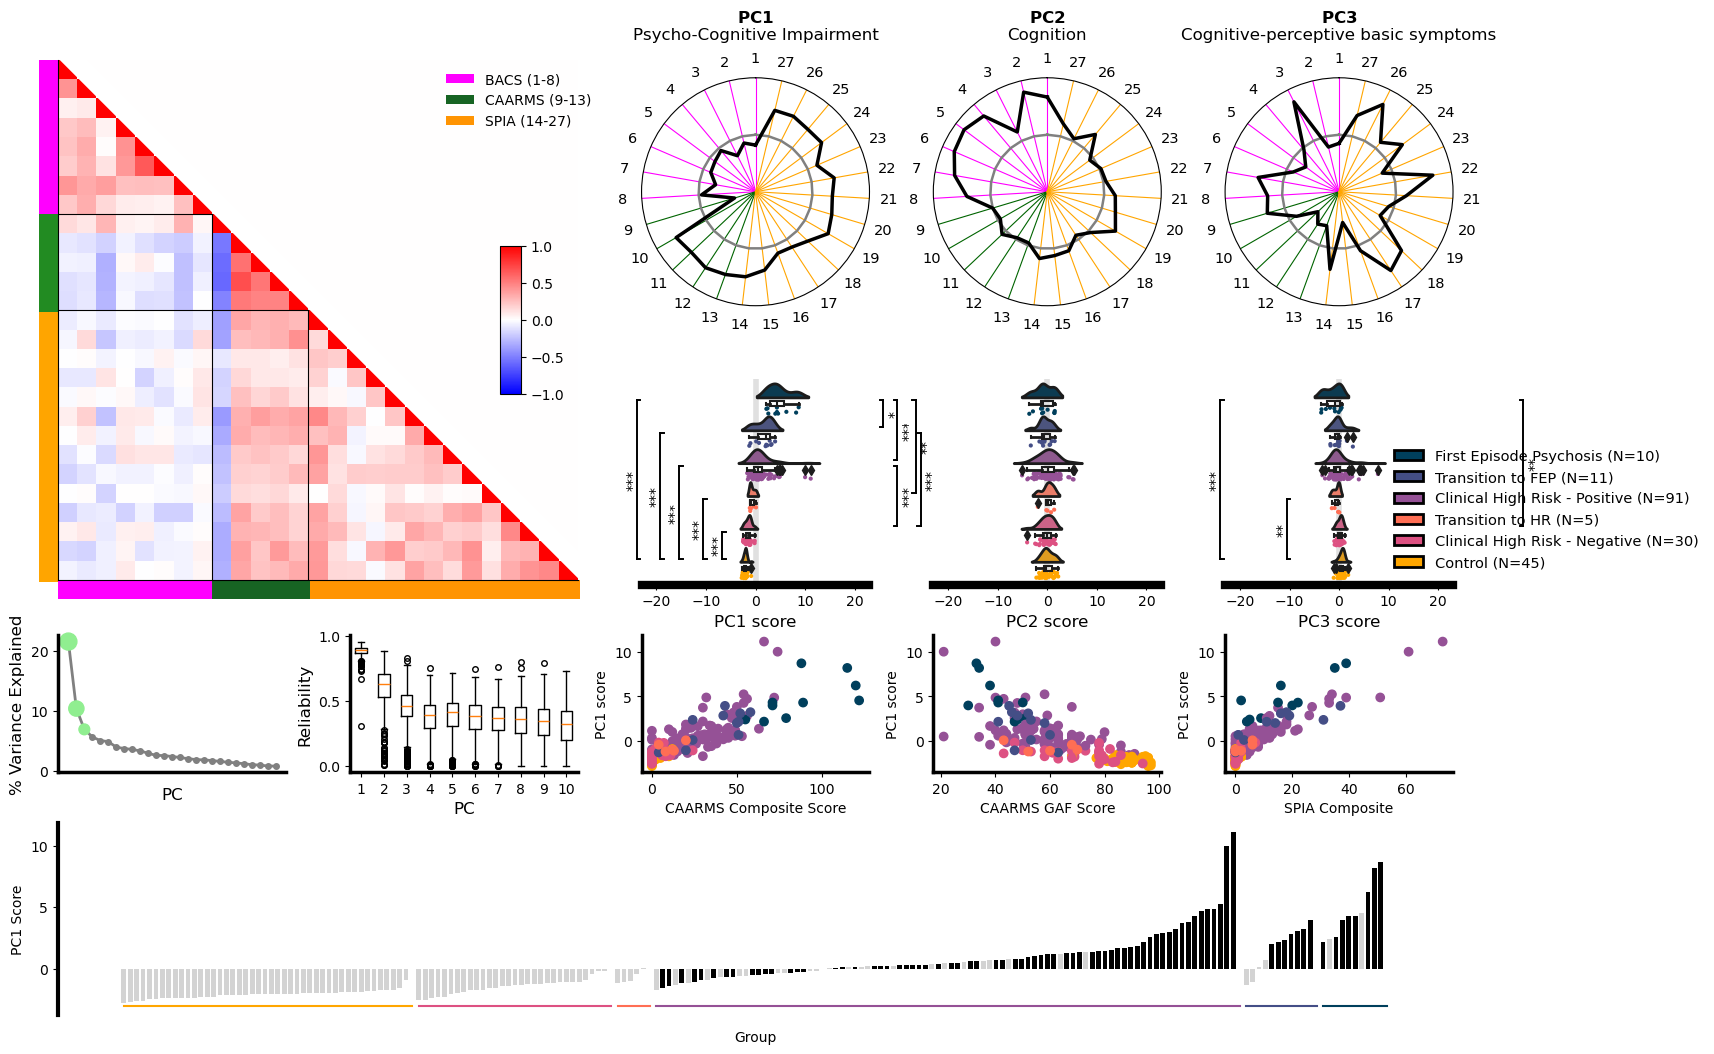

In [3]:
folder="/Users/sab322/glasgow/presentation/data"
prefix="NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_"
scores = pd.read_csv(f'{folder}/{prefix}BehaviorPCAScores_with_project.tsv', sep='\t')
loadings = pd.read_csv(f'{folder}/{prefix}BehaviorPCALoadings.tsv',sep='\t').drop(columns=['Unnamed: 0'])
loadings = loadings*-1
scores[['PC1','PC2','PC3']] = scores[['PC1','PC2','PC3']] *-1
corr_df = pd.read_csv(f'{folder}/{prefix}prep_AB_BehaviorCorrelation.tsv', sep='\t', header=None)
scree_df = pd.read_csv(f'{folder}/{prefix}prep_CA_BehaviorPCAScreeplot.tsv', sep='\t', header=None)
df_box = pd.read_csv('../data/boxplot_data_n187.csv')
caarms_df = pd.read_csv(f'{folder}/behavior_PassQC_CBS_ALL.tsv', sep='\t')
order = ['Control', 'Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP', 'First Episode Psychosis']
order.reverse()
create_plots(scores,loadings, corr_df, scree_df, df_box, caarms_df, order)

PassQC analysis, with 'converted' variable (from HR to FEP), includes transition data

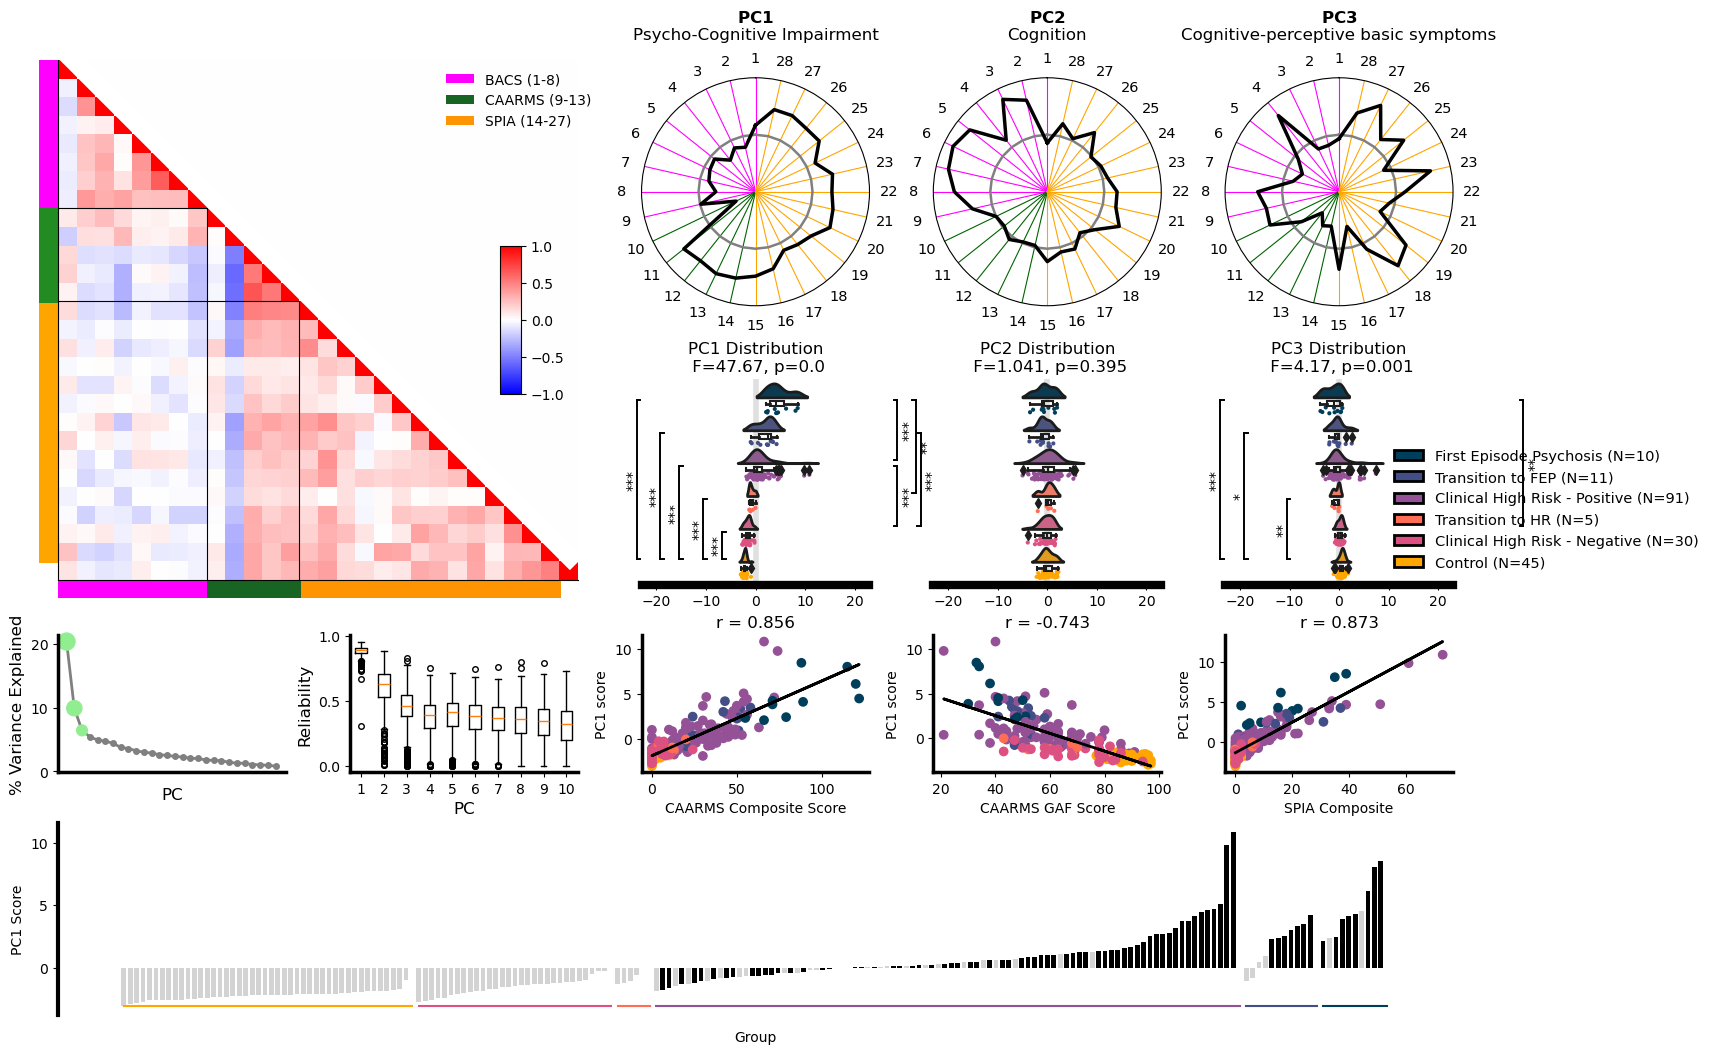

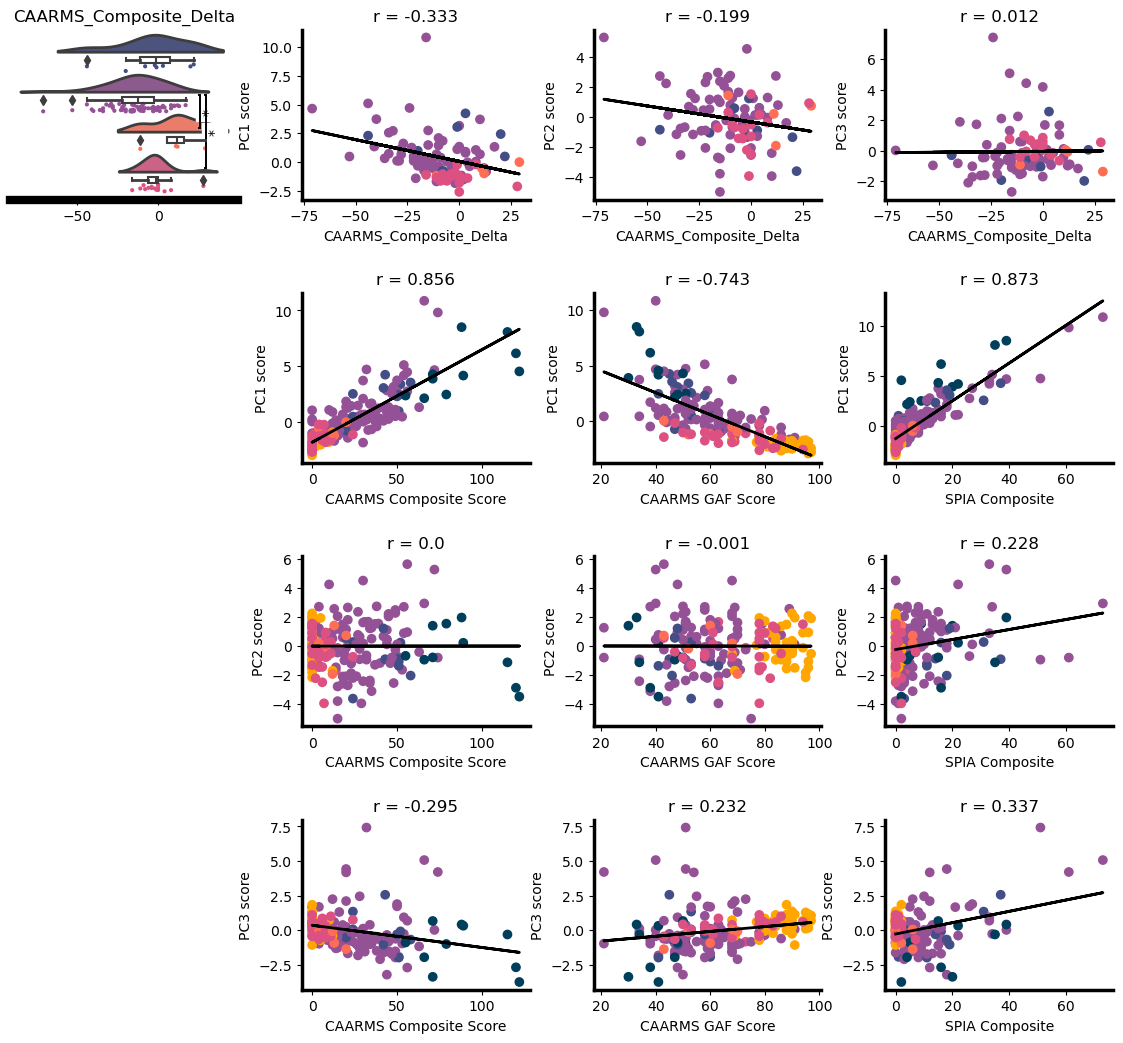

In [116]:
folder="/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_convert_ALL_n192/analysis"
prefix="NBRIDGE_Glasgow.collaboration_convert_ALL_n192_"
scores = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCAScores.tsv', sep='\t')
loadings = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCALoadings.tsv',sep='\t').drop(columns=['Unnamed: 0'])
loadings = loadings*-1
loadings.iloc[2] = loadings.iloc[2] *-1
scores[['PC1','PC2']] = scores[['PC1','PC2']] *-1
corr_df = pd.read_csv(f'{folder}/figures/{prefix}prep_AB_BehaviorCorrelation.tsv', sep='\t', header=None)
scree_df = pd.read_csv(f'{folder}/figures/{prefix}prep_CA_BehaviorPCAScreeplot.tsv', sep='\t', header=None)
df_box = pd.read_csv('../data/boxplot_data_n187.csv')
caarms_df = pd.read_csv(f'/Users/sab322/glasgow/presentation/data/behavior_convert_ALL.tsv', sep='\t')
order = ['Control', 'Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP', 'First Episode Psychosis']
order.reverse()
create_plots(scores,loadings, corr_df, scree_df, df_box, caarms_df, order, thresholds=[9,14,28])
delta_df = pd.read_csv('/Users/sab322/glasgow/presentation/data/behavior_followup_ALL.tsv', sep='\t')
supplement_plots(scores, caarms_df, delta_df)

Control-comparison

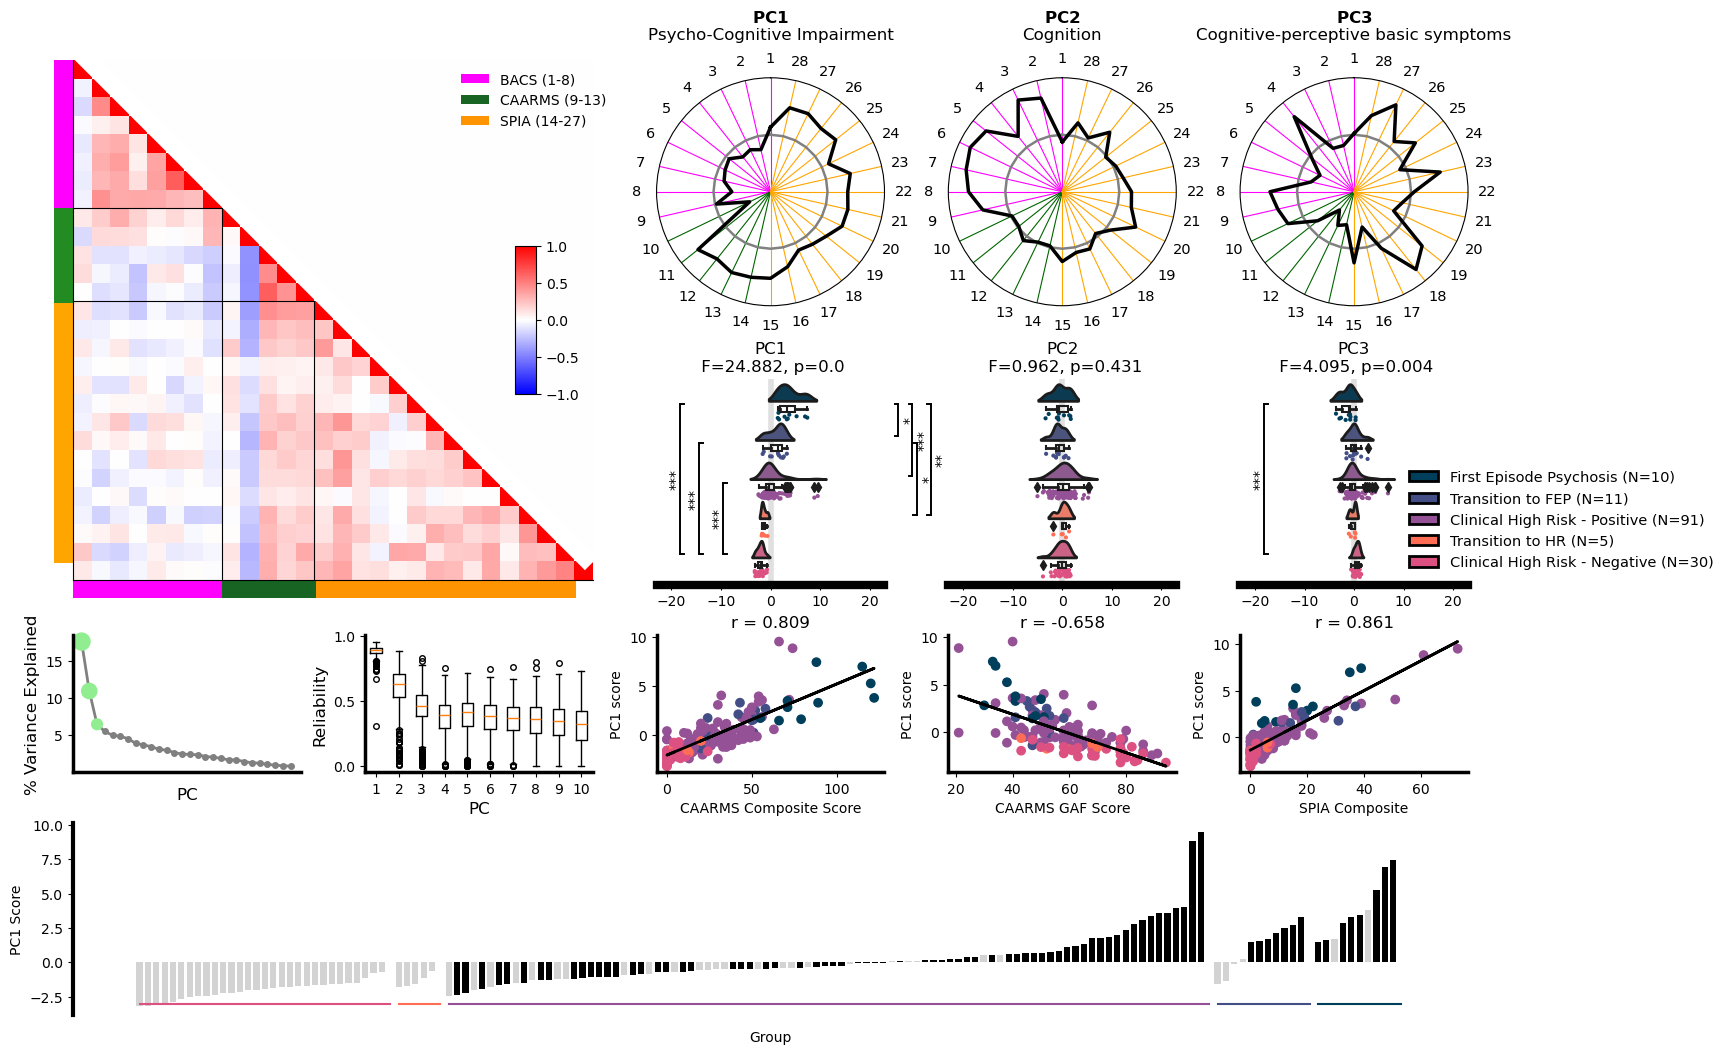

ValueError: Length of values (192) does not match length of index (147)

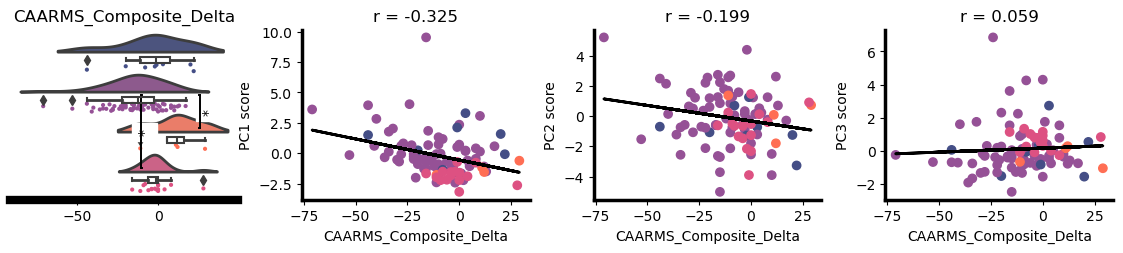

In [540]:
folder="/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_convert_NCON_control_analysis/analysis"
prefix="NBRIDGE_Glasgow.collaboration_convert_NCON_control_analysis_"
scores = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCAScores.tsv', sep='\t')
loadings = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCALoadings.tsv',sep='\t').drop(columns=['Unnamed: 0'])
#loadings = loadings*-1
#loadings.iloc[2] = loadings.iloc[2] *-1
#scores[['PC1','PC2']] = scores[['PC1','PC2']] *-1
corr_df = pd.read_csv(f'{folder}/figures/{prefix}prep_AB_BehaviorCorrelation.tsv', sep='\t', header=None)
scree_df = pd.read_csv(f'{folder}/figures/{prefix}prep_CA_BehaviorPCAScreeplot.tsv', sep='\t', header=None)
df_box = pd.read_csv('../data/boxplot_data_n187.csv')
caarms_df = pd.read_csv(f'/Users/sab322/glasgow/presentation/data/behavior_convert_ALL.tsv', sep='\t')
order = ['Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP', 'First Episode Psychosis']
order.reverse()
create_plots(scores,loadings, corr_df, scree_df, df_box, caarms_df, order, thresholds=[9,14,28])
delta_df = pd.read_csv('/Users/sab322/glasgow/presentation/data/behavior_followup_ALL.tsv', sep='\t')
supplement_plots(scores, caarms_df, delta_df)

Only subjects with follow-up data analysis, with 'converted' variable, without delta variables

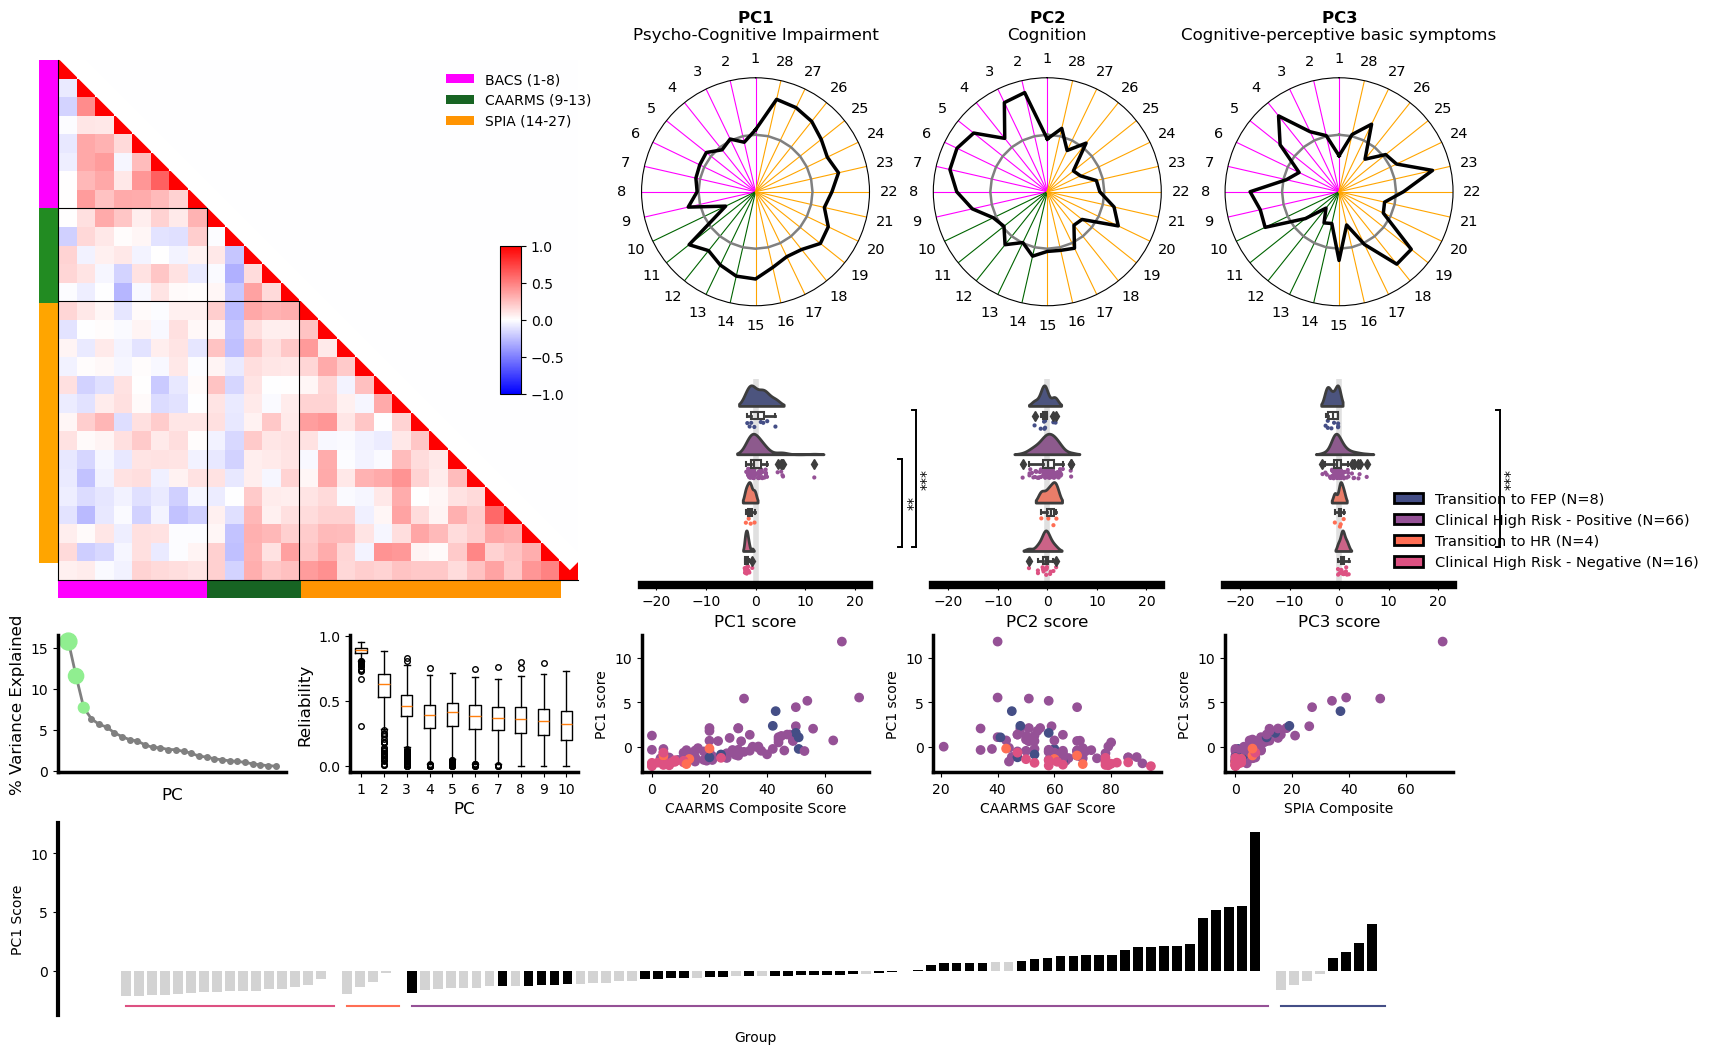

In [20]:
folder="/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_followup_ALL_NoDelta_n94/analysis"
prefix="NBRIDGE_Glasgow.collaboration_followup_ALL_NoDelta_n94_"
scores = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCAScores.tsv', sep='\t')
loadings = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCALoadings.tsv',sep='\t').drop(columns=['Unnamed: 0'])
#loadings = loadings*-1
loadings.iloc[2] = loadings.iloc[2] *-1
scores[['PC3']] = scores[['PC3']] *-1
corr_df = pd.read_csv(f'{folder}/figures/{prefix}prep_AB_BehaviorCorrelation.tsv', sep='\t', header=None)
scree_df = pd.read_csv(f'{folder}/figures/{prefix}prep_CA_BehaviorPCAScreeplot.tsv', sep='\t', header=None)
df_box = pd.read_csv('../data/boxplot_data_n187.csv')
caarms_df = pd.read_csv(f'/Users/sab322/glasgow/presentation/data/behavior_followup_ALL_NoDelta.tsv', sep='\t')
order = ['Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP']
order.reverse()
create_plots(scores,loadings, corr_df, scree_df, df_box, caarms_df, order, thresholds=[9,14,28])

Only subjects with follow-up data analysis, with 'converted' variable, with delta variables

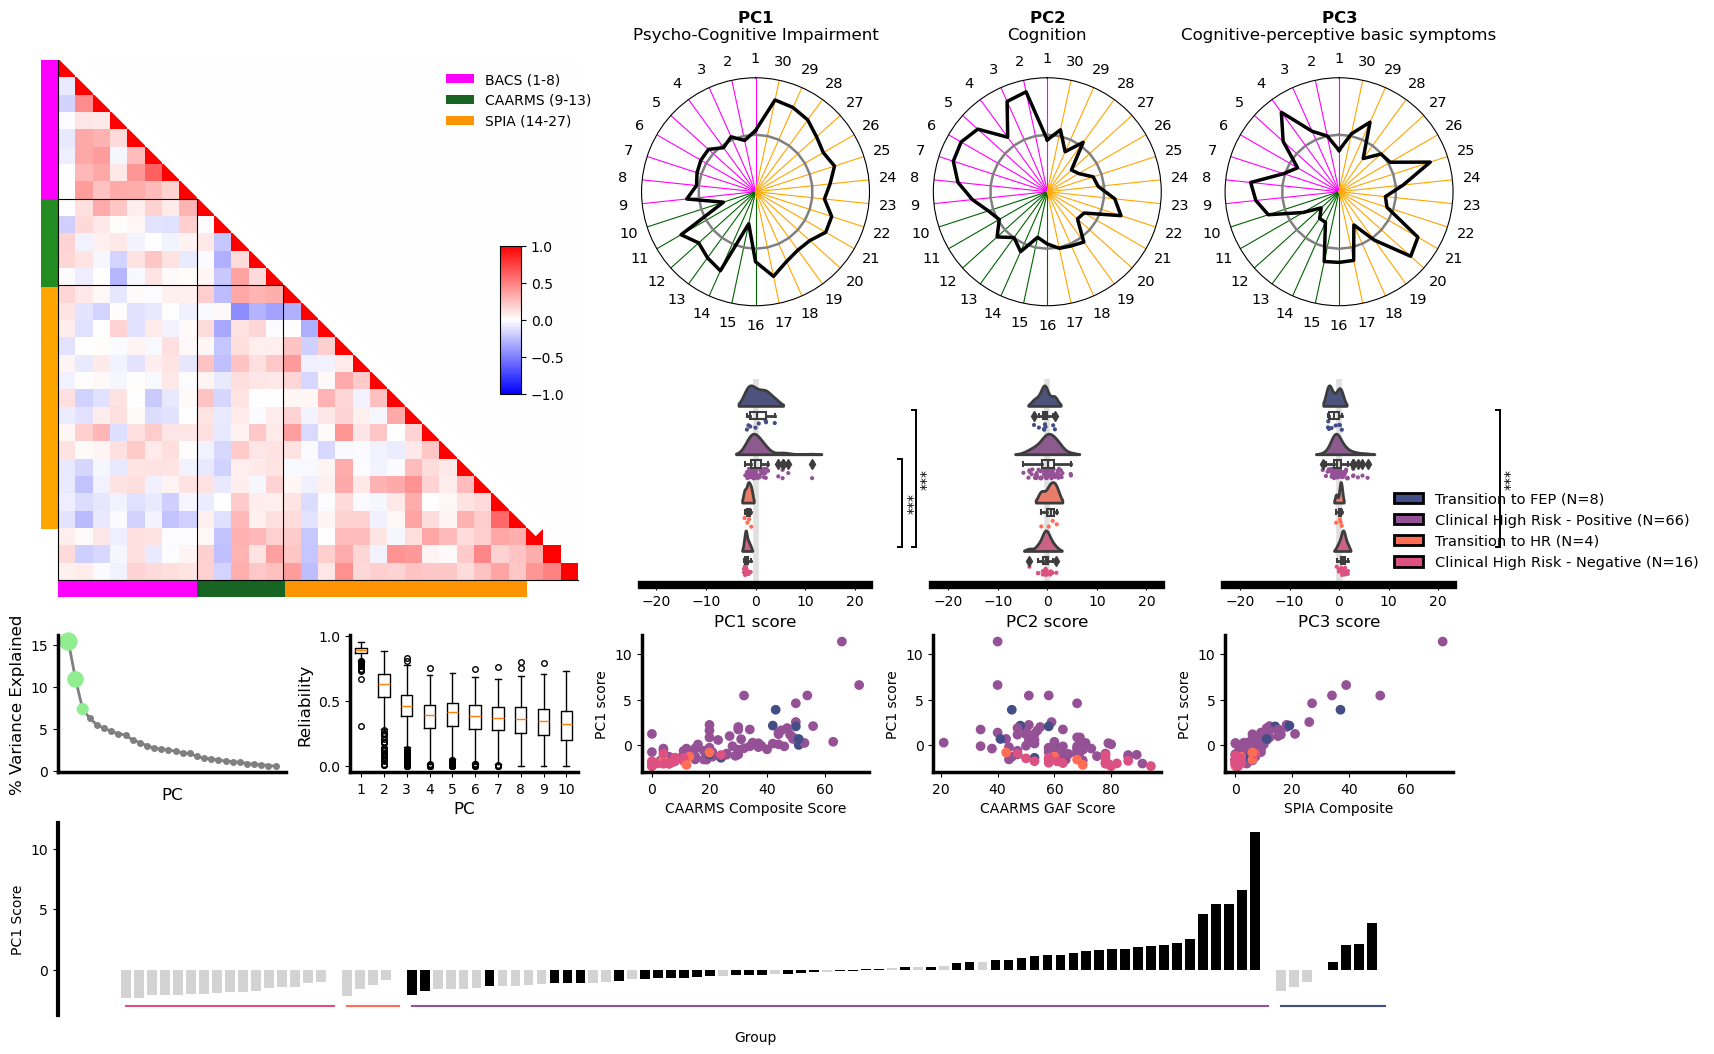

In [17]:
folder="/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_followup_ALL_Delta_n94/analysis"
prefix="NBRIDGE_Glasgow.collaboration_followup_ALL_Delta_n94_"
scores = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCAScores.tsv', sep='\t')
loadings = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCALoadings.tsv',sep='\t').drop(columns=['Unnamed: 0'])
#loadings = loadings*-1
loadings.iloc[2] = loadings.iloc[2] *-1
scores[['PC3']] = scores[['PC3']] *-1
corr_df = pd.read_csv(f'{folder}/figures/{prefix}prep_AB_BehaviorCorrelation.tsv', sep='\t', header=None)
scree_df = pd.read_csv(f'{folder}/figures/{prefix}prep_CA_BehaviorPCAScreeplot.tsv', sep='\t', header=None)
df_box = pd.read_csv('../data/boxplot_data_n187.csv')
caarms_df = pd.read_csv(f'/Users/sab322/glasgow/presentation/data/behavior_followup_ALL.tsv', sep='\t')
order = ['Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP']
order.reverse()
create_plots(scores,loadings, corr_df, scree_df, df_box, caarms_df, order, thresholds=[9,16,30])

Only subjects with follow-up data analysis, with only delta variables

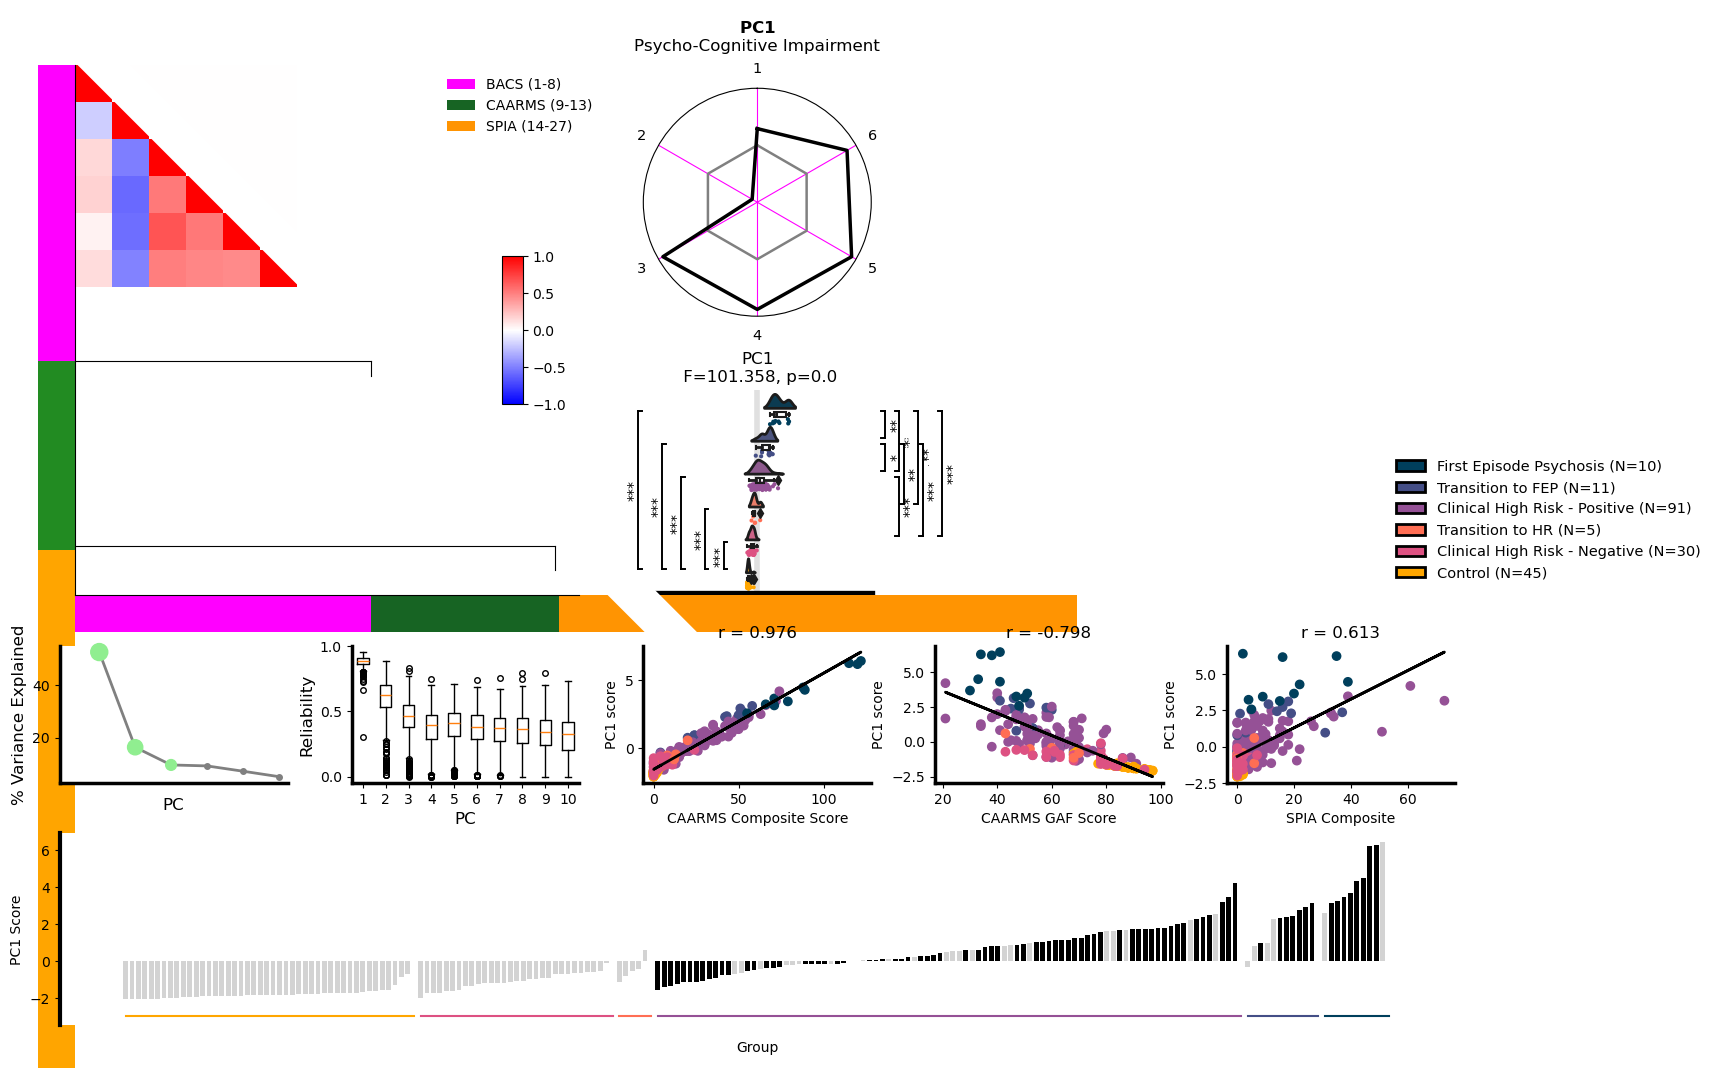

In [266]:
folder="/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_baseline_CAARMS_n192/analysis"
prefix="NBRIDGE_Glasgow.collaboration_baseline_CAARMS_n192_"
scores = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCAScores.tsv', sep='\t')
loadings = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCALoadings.tsv',sep='\t').drop(columns=['Unnamed: 0'])
#loadings = loadings*-1
#loadings.iloc[2] = loadings.iloc[2] *-1
#scores[['PC3']] = scores[['PC3']] *-1
corr_df = pd.read_csv(f'{folder}/figures/{prefix}prep_AB_BehaviorCorrelation.tsv', sep='\t', header=None)
scree_df = pd.read_csv(f'{folder}/figures/{prefix}prep_CA_BehaviorPCAScreeplot.tsv', sep='\t', header=None)
df_box = pd.read_csv('../data/boxplot_data_n187.csv')
caarms_df = pd.read_csv(f'/Users/sab322/glasgow/presentation/data/behavior_convert_ALL.tsv', sep='\t')
order = ['Control', 'Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP', 'First Episode Psychosis']
order.reverse()
create_plots(scores,loadings, corr_df, scree_df, df_box, caarms_df, order, thresholds=[9,16,30], pcs=1)

In [115]:
folder="/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_baseline_CAARMS_n192/analysis"
prefix="NBRIDGE_Glasgow.collaboration_baseline_CAARMS_n192_"
scores = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCAScores.tsv', sep='\t')
loadings = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCALoadings.tsv',sep='\t').drop(columns=['Unnamed: 0'])
followup_beh = pd.read_csv('../data/caarms_followup_all_more.tsv', sep='\t')
convert_df = pd.read_csv(f'/Users/sab322/glasgow/presentation/data/behavior_convert_ALL.tsv', sep='\t')[['participant_id','Converted']]
followup_beh = convert_df.merge(followup_beh, how='left', on='participant_id')
from scipy.stats import zscore
numeric_cols = followup_beh.select_dtypes(include=[np.number]).columns
followup_beh[numeric_cols] = followup_beh[numeric_cols].apply(zscore)
l_arr = loadings.to_numpy()
new_scores = pd.DataFrame()
new_scores[['participant_id', 'Group']] = followup_beh[followup_beh['date']=='baseline'][['participant_id', 'Group']]
for date in followup_beh['date'].unique():
    date_df = followup_beh[followup_beh['date'] == date].copy()
    d_arr = date_df.filter(regex='Converted|CAARMS').to_numpy()
    d_scores = l_arr@d_arr.T
    date_df[f'PC1_{date}'] = d_scores[0]
    new_scores = new_scores.merge(date_df[['participant_id',f'PC1_{date}']], how='left', on='participant_id')


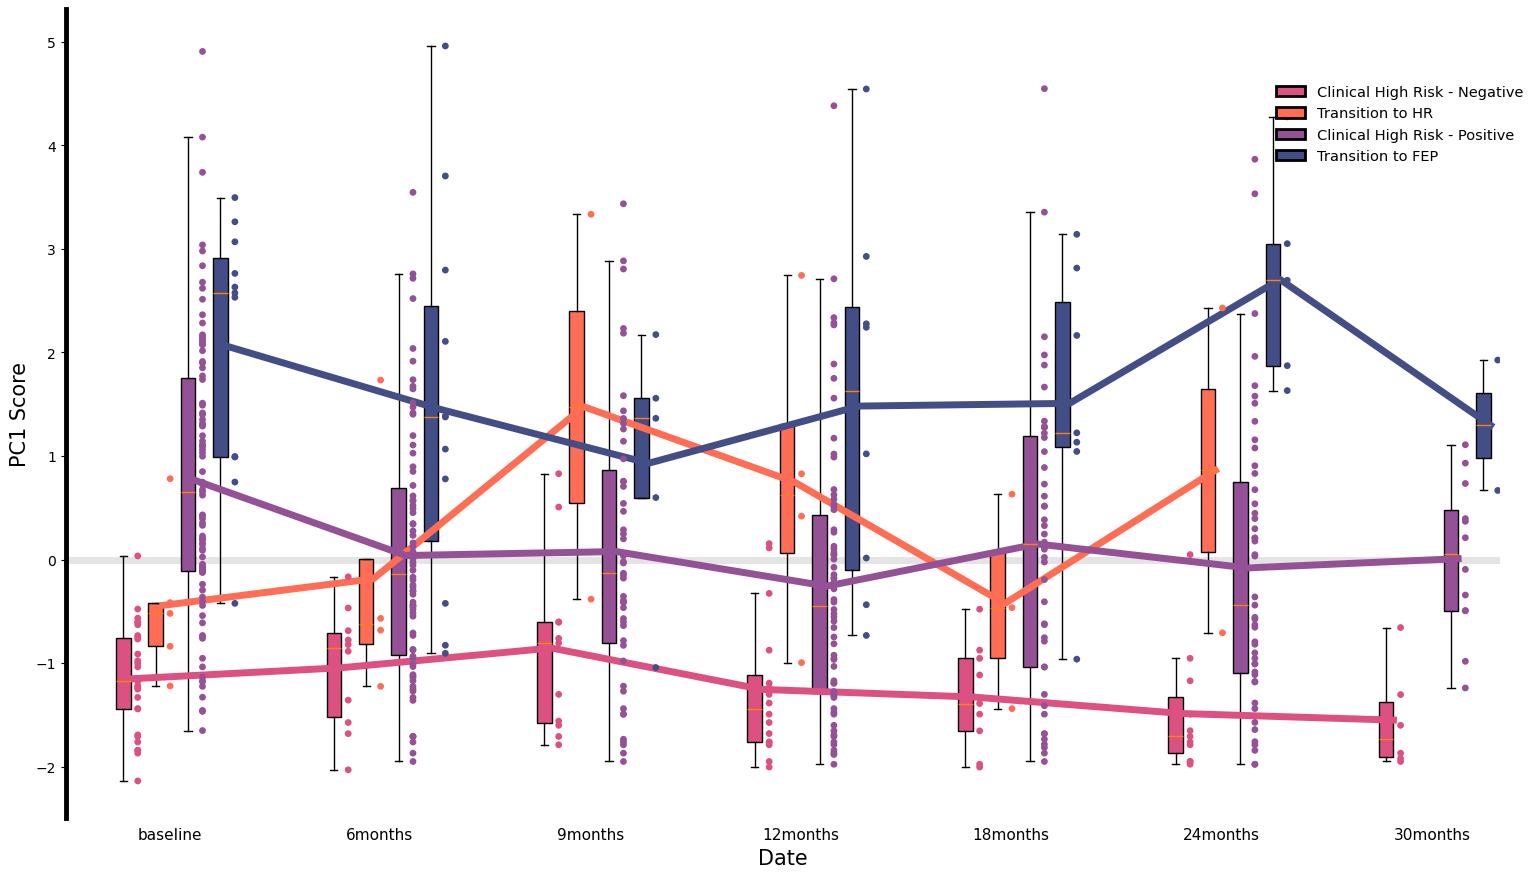

In [216]:
new_scores

order = ['Clinical High Risk - Negative', 'Transition to HR', 'Clinical High Risk - Positive', 'Transition to FEP']
cDict = {'First Episode Psychosis':"#003f5c", 'Transition to FEP':"#444e86", 'Clinical High Risk - Positive':"#955196",
    'Clinical High Risk - Negative':"#dd5182", 'Transition to HR':"#ff6e54", 'Control':"#ffa600"}

cPalette = [cDict[group] for group in order]

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

x = 1
spacing = 6.5
jitter = 1
subspacing = 4.5

dates = ['baseline', '6months', '9months','12months', '18months', '24months', '30months']

for date in dates:
    col = f"PC1_{date}"
    box_data = []
    labels = []
    scatter = [[],[],[]]

    x_pos = [x-2*jitter,x-jitter,x,x+jitter]
    for group, x_p in zip(order, x_pos):
        y = new_scores[col][new_scores['Group'] == group].dropna().to_list()
        box_data.append(y)
        labels.append(group)
        scatter[1] += y
        scatter[0] += [x_p+jitter/subspacing] * len(y)
        scatter[2] += [cDict[group]] * len(y)

    bplot = ax.boxplot(box_data, patch_artist=True, positions=[x_p-jitter/subspacing for x_p in x_pos], vert=True, showfliers=False)
    splot = ax.scatter(scatter[0], scatter[1], c=scatter[2], zorder=50, s=15)

    x+=spacing
    for patch, color in zip(bplot['boxes'], cPalette):
        patch.set_facecolor(color)

mean_scores = []

start=1-2*jitter
for group in order:
    pc1_mean = new_scores[new_scores['Group'] == group].filter(regex='PC1').mean().to_numpy()
    x = np.arange(start, (len(pc1_mean)*spacing + start), spacing)
    mean_scores.append(pc1_mean)
    ax.plot(x, pc1_mean, c=cDict[group], label=group, lw=5)
    start += jitter

# ort = "h"; sigma = .5; cut=1.7; move=0.2; linewidth=2; 
# scale=0.85; pointplot=False
ax.spines[['right', 'top', 'bottom']].set_visible(False)
#ax.spines.bottom.set(linewidth=3.5)
ax.spines.left.set(linewidth=3.5)

label_offset = 0.2

ax.set_xticks(np.arange(label_offset, (len(dates)*spacing+label_offset), spacing))
ax.set_xticklabels(dates, size=11)
ax.xaxis.set_ticks_position('none')
ax.set_xlim(-3)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("PC1 Score", size=15)

legend_elements = []
#legendLabels.reverse()
for i in range(len(order)):
    legend_elements.append(Patch(facecolor=cPalette[i], edgecolor='black', linewidth=2, label=order[i]))

xmin = ax.get_xlim()[0]
xmax = ax.get_xlim()[1]
ax.plot([xmin,xmax], [0,0], c='lightgrey', lw=5, zorder=0, alpha=0.6)
fig.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(0.92,0.82), frameon=False, prop={'size': 10.5})
# ax=pt.RainCloud(x = 'Group', y = 'PC1_baseline', data = df, palette = cPalette, bw = sigma, cut=cut, order=order, pointplot=pointplot,
#                     width_viol = scale, ax = ax, orient = ort, move = move, scale="width", linewidth = linewidth, linecolor="red")
plt.show()

In [125]:
new_scores.columns

Index(['participant_id', 'Group', 'PC1_baseline', 'PC1_6months', 'PC1_9months',
       'PC1_12months', 'PC1_18months', 'PC1_24months', 'PC1_30months'],
      dtype='object')

In [5]:
plt.scatter()

Group participant_id       PC1
0    Clinical High Risk - Positive          BDA15 -0.163572
1    Clinical High Risk - Positive          CMH10  2.068308
2                Transition to FEP          APS28  2.730126
3    Clinical High Risk - Positive          JSA14  0.777721
4                Transition to FEP          HSS25  2.275460
..                             ...            ...       ...
187  Clinical High Risk - Negative          LTE22 -1.096924
188  Clinical High Risk - Negative          JBR31 -0.929813
189  Clinical High Risk - Negative          CBA31 -1.649462
190  Clinical High Risk - Negative          BWH17 -0.110770
191  Clinical High Risk - Negative          GRO29 -1.372841

[192 rows x 3 columns]

Follow-up exploration: do CHR-P transition down?

In [195]:
df = pd.read_csv('../data/behavior_followup_ALL.tsv', sep='\t')
id_df = pd.read_csv('../csvs/YouR_Study_All_Misc.csv')[['Study_ID','Scan_ID']].rename(columns={'Scan_ID':'participant_id'})
caarms_12month = pd.read_csv('../csvs/CAARMS_12months.csv')
groups_12month = caarms_12month[['Study_ID', 'CAARMS_Group_12months']]
arms_df = pd.read_csv('../csvs/CAARMS_baseline.csv')[['Study_ID', 'CAARMS_group_baseline_final_score']]
mapper_arms = {'0':'None','1':'Attenuated Psychosis Group','3':'Vulnerability Group','4':'Psychosis Threshold', '5':'Attenuated Psychosis + Vulnerability'}
arms_df['CAARMS_group_baseline_final_score'] = arms_df['CAARMS_group_baseline_final_score'].map(mapper_arms)
groups_12month['CAARMS_Group_12months'] = groups_12month['CAARMS_Group_12months'].map(mapper_arms)

merged_df = id_df.merge(arms_df, how='left', on='Study_ID').merge(groups_12month, how='left', on='Study_ID')
merged_df = merged_df.drop(columns='Study_ID')
merged_df = df.merge(merged_df, how='left', on='participant_id')

group_baseline = merged_df['CAARMS_group_baseline_final_score'].to_list()
group_followup = merged_df['CAARMS_Group_12months'].to_list()
group_transition = []
rank_transition = []

for base, followup in zip(group_baseline, group_followup):
    group_transition.append(f"{base}>{followup}")
    if base == "None" and followup == "None":
        rank_transition.append("None")
    elif base == "None":
        rank_transition.append("Transition to AP")
    elif followup == "None":
        rank_transition.append("Transition to None")
    elif base == followup:
        rank_transition.append("Remain AP")
    else:
        rank_transition.append("AP to Psychosis Threshold")

merged_df['CAARMS_group_transition'] = group_transition
merged_df['CAARMS_group_transition_type'] = rank_transition

scores = pd.read_csv('/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_convert_ALL_n192/analysis/results/NBRIDGE_Glasgow.collaboration_convert_ALL_n192_BehaviorPCAScores.tsv', sep='\t')
scores[['PC1','PC2']] = scores[['PC1','PC2']] *-1
merged_df = merged_df.merge(scores[['participant_id', 'PC1', 'PC2', 'PC3']], 'left', 'participant_id')

c_comp_cols = ['CAARMS_UTC_severity','CAARMS_NBI_severity', 'CAARMS_PA_severity', 'CAARMS_DS_severity']
merged_df['CAARMS Composite'] = merged_df[c_comp_cols].sum(axis=1).to_numpy()

merged_df['SPIA Composite'] = merged_df.filter(regex='SPIA').sum(axis=1)

/var/folders/_f/51yc4jgj2yb300z_hgqpzxq59rm7sh/T/ipykernel_9922/2274827522.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groups_12month['CAARMS_Group_12months'] = groups_12month['CAARMS_Group_12months'].map(mapper_arms)


In [222]:
merged_df['CAARMS_group_baseline_final_score'].value_counts()

CAARMS_group_baseline_final_score
Attenuated Psychosis Group    56
None                          37
Vulnerability Group            1
Name: count, dtype: int64

In [223]:
merged_df[['Group','CAARMS_group_baseline_final_score']].value_counts()

Group                          CAARMS_group_baseline_final_score
Clinical High Risk - Positive  Attenuated Psychosis Group           50
Clinical High Risk - Negative  None                                 16
Clinical High Risk - Positive  None                                 16
Transition to FEP              Attenuated Psychosis Group            6
Transition to HR               None                                  4
Transition to FEP              None                                  1
                               Vulnerability Group                   1
Name: count, dtype: int64

In [224]:
merged_df['CAARMS_Group_12months'].value_counts()

CAARMS_Group_12months
None                          61
Attenuated Psychosis Group    31
Psychosis Threshold            2
Name: count, dtype: int64

In [225]:
merged_df[['Group','CAARMS_Group_12months']].value_counts()

Group                          CAARMS_Group_12months     
Clinical High Risk - Positive  None                          42
                               Attenuated Psychosis Group    24
Clinical High Risk - Negative  None                          15
Transition to FEP              Attenuated Psychosis Group     3
                               None                           3
Transition to HR               Attenuated Psychosis Group     3
Transition to FEP              Psychosis Threshold            2
Clinical High Risk - Negative  Attenuated Psychosis Group     1
Transition to HR               None                           1
Name: count, dtype: int64

In [192]:
merged_df['CAARMS_group_transition'].value_counts()

CAARMS_group_transition
None>None                                                30
Attenuated Psychosis Group>None                          30
Attenuated Psychosis Group>Attenuated Psychosis Group    24
None>Attenuated Psychosis Group                           7
Attenuated Psychosis Group>Psychosis Threshold            2
Vulnerability Group>None                                  1
Name: count, dtype: int64

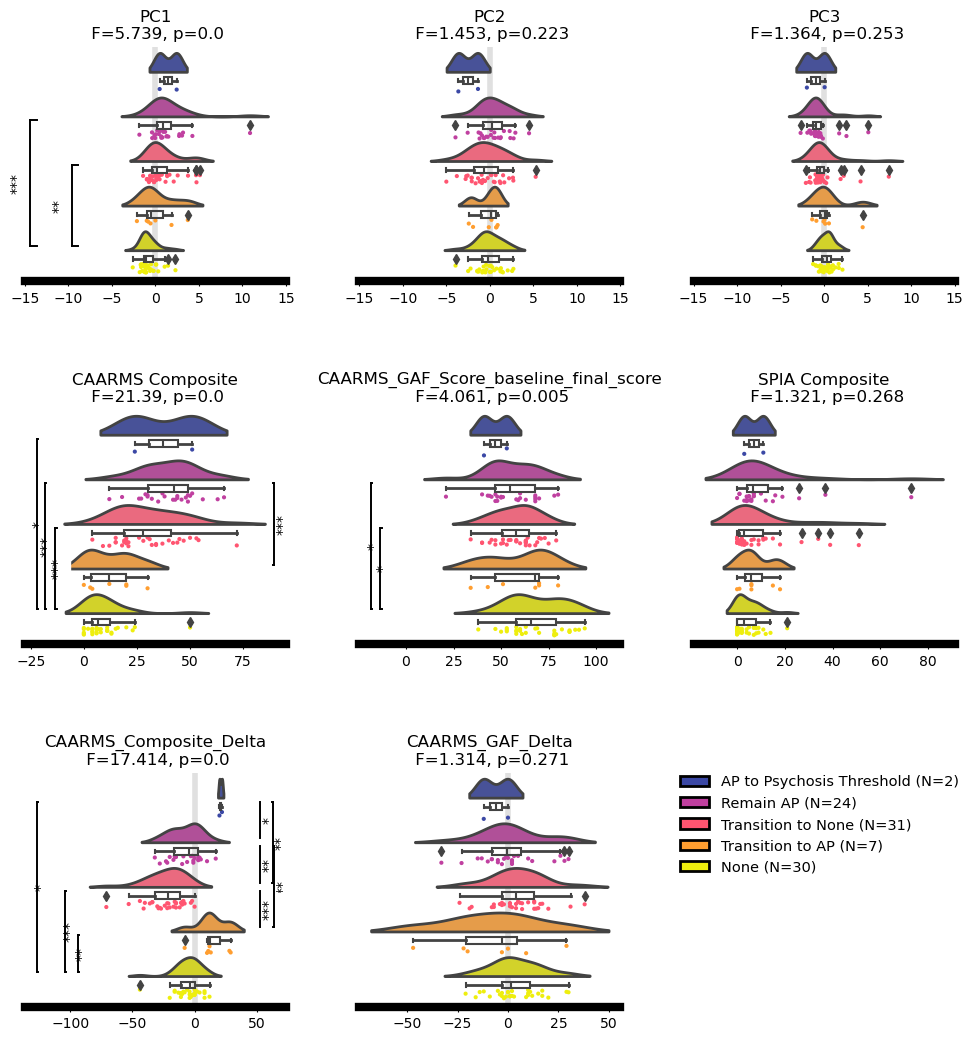

In [226]:
fig = plt.figure(figsize=(12,12))
spec = fig.add_gridspec(ncols=3,nrows=3)
fig.subplots_adjust(wspace=0.28, hspace=0.55, top=0.85, bottom=0.05)

arms_order = ['None', 'Transition to AP', 'Transition to None', 'Remain AP', 'AP to Psychosis Threshold']
arms_order.reverse()
arms_cDict = {'None':"#eeee0e",
                 'Transition to AP':"#ff9e30",
                 'Transition to None':"#ff5571",
                 'Remain AP':"#c040a0",
                 'AP to Psychosis Threshold':"#3b48a5"}

counts_df = merged_df["CAARMS_group_transition_type"].value_counts()
counts = []
legendLabels = []
arms_cPalette = []
for group in arms_order:
    counts.append(counts_df[group])
    legendLabels.append(f'{group} (N={counts_df[group]})')
    arms_cPalette.append(arms_cDict[group])

for i, var in enumerate(['PC1', 'PC2', 'PC3']):
    ax_rain = fig.add_subplot(spec[0,i])
    ax_rain.plot([0,0],[-20,20], zorder=0, color='lightgrey', lw=4, alpha=0.7)
    ax_rain = rain_plot(ax_rain, merged_df, arms_cPalette, arms_order, 'CAARMS_group_transition_type', var, True)
    ax_rain.set_xlim((-15,15))
    ax_rain.set(yticklabels=[])
    ax_rain.tick_params(left=False)

for i, var in enumerate(['CAARMS Composite', 'CAARMS_GAF_Score_baseline_final_score', 'SPIA Composite']):
    ax_rain = fig.add_subplot(spec[1,i])
    #ax_rain.plot([0,0],[-20,20], zorder=0, color='lightgrey', lw=4, alpha=0.7)
    ax_rain = rain_plot(ax_rain, merged_df, arms_cPalette, arms_order, 'CAARMS_group_transition_type', var, True, stat_start=[-9,84])
    #ax_rain.set_title(var)
    #ax_rain.set_xlim((-15,15))
    ax_rain.set(yticklabels=[])
    ax_rain.tick_params(left=False)

for i, var in enumerate(['CAARMS_Composite_Delta', 'CAARMS_GAF_Delta',]):
    ax_rain = fig.add_subplot(spec[2,i])
    ax_rain.plot([0,0],[-20,20], zorder=0, color='lightgrey', lw=4, alpha=0.7)
    ax_rain = rain_plot(ax_rain, merged_df, arms_cPalette, arms_order, 'CAARMS_group_transition_type', var, True, stat_start=[-85,44], stat_gap=9)
    #ax_rain.set_title(var)
    #ax_rain.set_xlim((-15,15))
    ax_rain.set(yticklabels=[])
    ax_rain.tick_params(left=False)

legend_elements = []
#legendLabels.reverse()
for i in range(len(legendLabels)):
    legend_elements.append(Patch(facecolor=arms_cPalette[i], edgecolor='black', linewidth=2, label=legendLabels[i]))

fig.legend(handles=legend_elements, loc="lower left", bbox_to_anchor=(0.66,0.15), frameon=False, prop={'size': 10.5})

In [244]:
df = pd.read_csv('../data/caarms_followup_all_more.tsv', sep='\t')
id_df = pd.read_csv('../csvs/YouR_Study_All_Misc.csv')[['Study_ID','Scan_ID']].rename(columns={'Scan_ID':'participant_id'})
mapper_arms = {'0':'None','1':'Attenuated Psychosis Group','3':'Vulnerability Group','4':'Psychosis Threshold', '5':'Attenuated Psychosis + Vulnerability'}

date_df = pd.read_csv(f'../csvs/CAARMS_baseline.csv')[['Study_ID', 'CAARMS_group_baseline_final_score']]
date_df['CAARMS_group_baseline_final_score'] = date_df['CAARMS_group_baseline_final_score'].map(mapper_arms)
date_df = date_df.rename(columns={'CAARMS_group_baseline_final_score': 'CAARMS_Group_baseline'})

merged_df = id_df.merge(date_df, how='left', on='Study_ID')

for date in df['date'].unique():
    if date != 'baseline':
        date_df = pd.read_csv(f'../csvs/CAARMS_{date}.csv')[['Study_ID', f'CAARMS_Group_{date}']]
        date_df[f'CAARMS_Group_{date}'] = date_df[f'CAARMS_Group_{date}'].map(mapper_arms)
        merged_df = merged_df.merge(date_df, how='left', on='Study_ID')

QC_df =  pd.read_csv('../data/behavior_convert_ALL.tsv', sep = '\t')[['participant_id','Group']]
#QC_ids = QC_df['participant_id'].to_list()
#merged_df = merged_df[merged_df['participant_id'].isin(QC_ids)].reset_index()
merged_df = QC_df.merge(merged_df, how='left', on='participant_id').reset_index()
#merged

In [245]:
merged_df

index participant_id                          Group Study_ID  \
0        0          BDA15  Clinical High Risk - Positive    EA001   
1        1          CMH10  Clinical High Risk - Positive    EA003   
2        2          APS28              Transition to FEP    EA005   
3        3          JSA14  Clinical High Risk - Positive    EA007   
4        4          HSS25              Transition to FEP    EA008   
..     ...            ...                            ...      ...   
187    187          LTE22  Clinical High Risk - Negative    GL037   
188    188          JBR31  Clinical High Risk - Negative    GL038   
189    189          CBA31  Clinical High Risk - Negative    GL042   
190    190          BWH17  Clinical High Risk - Negative    GL043   
191    191          GRO29  Clinical High Risk - Negative    GL004   

          CAARMS_Group_baseline        CAARMS_Group_6months  \
0                          None                        None   
1    Attenuated Psychosis Group                        None   
2    Attenuated Psychosis Group                        None   
3    Attenuated Psychosis Group  Attenuated Psychosis Group   
4    Attenuated Psychosis Group  Attenuated Psychosis Group   
..                          ...                         ...   
187                        None                         NaN   
188                        None                        None   
189                        None                        None   
190                        None                        None   
191                        None                        None   

           CAARMS_Group_9months       CAARMS_Group_12months  \
0                          None                        None   
1    Attenuated Psychosis Group                        None   
2           Psychosis Threshold  Attenuated Psychosis Group   
3                          None                        None   
4    Attenuated Psychosis Group  Attenuated Psychosis Group   
..                          ...                         ...   
187                         NaN                        None   
188                         NaN                        None   
189                        None  Attenuated Psychosis Group   
190                         NaN                        None   
191                        None                        None   

          CAARMS_Group_18months       CAARMS_Group_24months  \
0                          None                        None   
1    Attenuated Psychosis Group  Attenuated Psychosis Group   
2    Attenuated Psychosis Group  Attenuated Psychosis Group   
3                          None                        None   
4    Attenuated Psychosis Group         Psychosis Threshold   
..                          ...                         ...   
187                        None                        None   
188                         NaN                        None   
189                         NaN                        None   
190                         NaN                         NaN   
191                         NaN                         NaN   

          CAARMS_Group_30months  
0    Attenuated Psychosis Group  
1    Attenuated Psychosis Group  
2    Attenuated Psychosis Group  
3                           NaN  
4    Attenuated Psychosis Group  
..                          ...  
187                         NaN  
188                         NaN  
189                         NaN  
190                         NaN  
191                         NaN  

[192 rows x 11 columns]

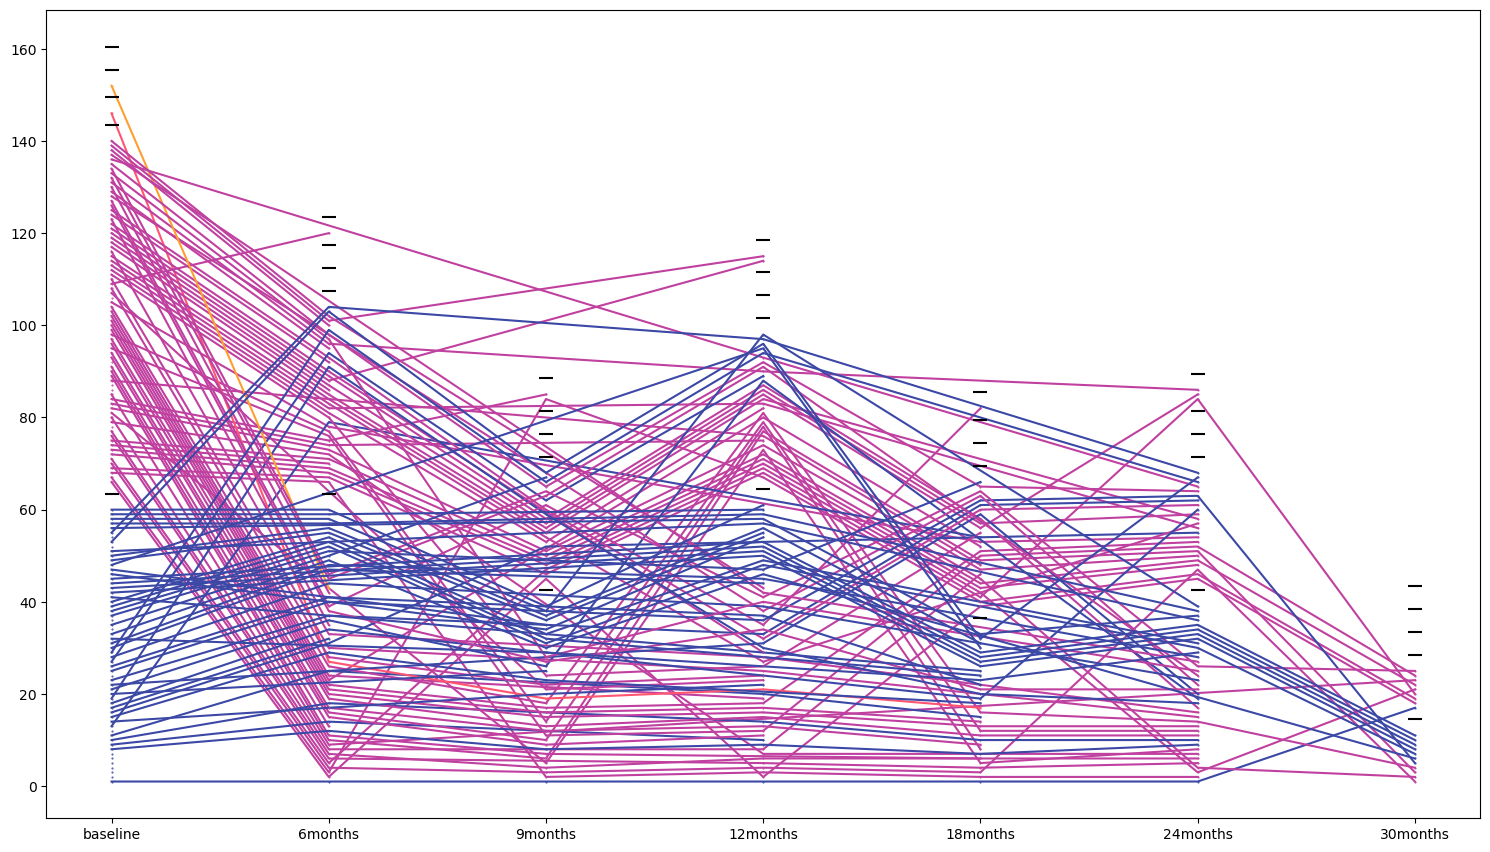

In [248]:
from matplotlib.collections import LineCollection
import warnings

def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

#fig = plt.figure(figsize=(12,8))
#spec = fig.add_gridspec(ncols=1,nrows=1)
#fig.subplots_adjust(wspace=0.28, hspace=0.55, top=0.85, bottom=0.05)

merged_df = merged_df[(merged_df['Group'] != 'Control') & (merged_df['Group'] != 'First Episode Psychosis')].reset_index()

dates = ['baseline', '6months', '9months', '12months', '18months', '24months', '30months']
arms_order = ['None', 'Attenuated Psychosis Group', 'Vulnerability Group', 'Attenuated Psychosis + Vulnerability', 'Psychosis Threshold']
arms_cDict = {'None':"#eeee0e",
                 'Attenuated Psychosis Group':"#ff9e30",
                 'Vulnerability Group':"#ff5571",
                 'Attenuated Psychosis + Vulnerability':"#c040a0",
                 'Psychosis Threshold':"#3b48a5"}

arms_cPalette = [arms_cDict[a] for a in arms_order]

#Stores line at each index in the dataframe
line_arr = np.zeros((2, merged_df.shape[0], len(dates), 2), dtype=np.int32)
#Indices where group changes
cat_list = []

gap = 5

d_i = 0
first = True
for date in dates:
    end_list = []
    start_i = 1
    a_i = 1
    for arms in arms_order:
        ind = merged_df[merged_df[f'CAARMS_Group_{date}'] == arms].index
        end_i = start_i + len(ind)
        end_list.append([d_i, end_i+gap/2])
        line_arr[0,ind,d_i,0] = np.arange(start_i, end_i)
        line_arr[0,ind,d_i,1] = d_i
        line_arr[1,ind,d_i] = a_i
        start_i = end_i + gap
        a_i += 1
    cat_list.append(end_list)
    d_i+=1
    first = False

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
#plot = fig.add_subplot(spec[0,0])
arms_order.reverse()
for row in range(len(line_arr[0])):
    scrubbed = [ele for ele in line_arr[0][row] if ele[0] != 0]
    scrubbed_c = [arms_cDict[arms_order[ele[0]-1]] for ele in line_arr[1][row] if ele[0] != 0]
    if len(scrubbed) != 0:
        line = np.vstack(scrubbed)
        ax.plot(line[:,1], line[:,0], color=scrubbed_c[0], zorder=0)
        ax.scatter(line[:,1], line[:,0], color=scrubbed_c[0], s=1, marker='.')
        #print(line[:,1])
        #print(line[:,0])
        #print(scrubbed_c)
        #print("")
        #ax.scatter(line[:,1], line[:,0], c=scrubbed_c, cmap='rainbow')
        #colored_line(line[:,1], line[:,0], c=scrubbed_c, ax=ax, cmap='rainbow')

for row in cat_list:
    for col in row:
        ax.scatter(col[0],col[1], color='black', s=100, marker="_")

ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(dates)
#for col in merged_df.columns:
        # v_dict = merged_df[f'CAARMS_Group_{date}'].value_counts()
        # s_i = 0
        # for arms in arms_order:
        #     np.arange(s_i, v_dict[arms])
        #     s_i += v_dict[arms]

plt.show()


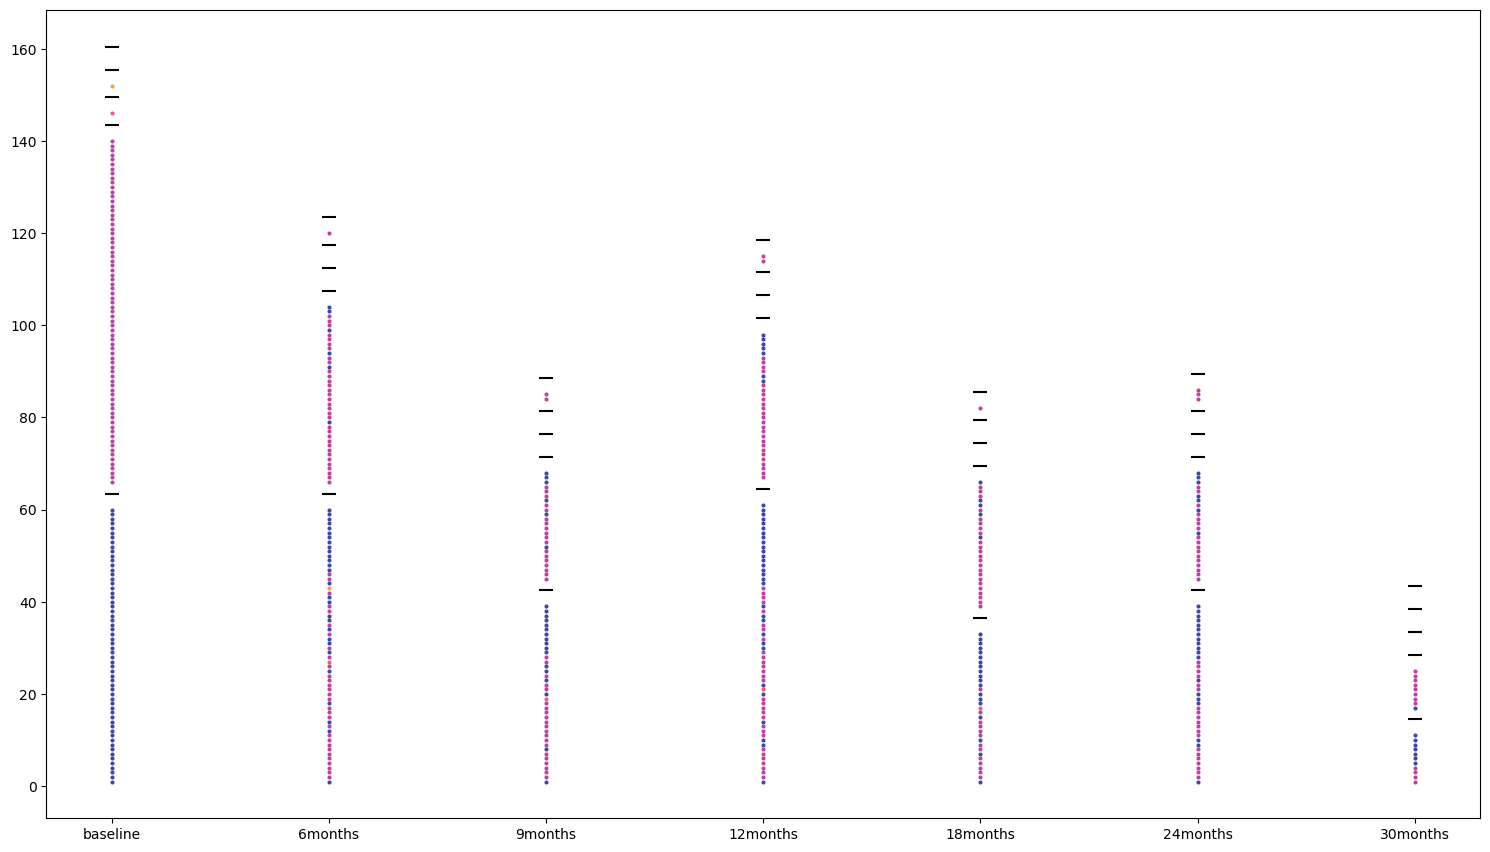

In [249]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
#plot = fig.add_subplot(spec[0,0])
for row in range(len(line_arr[0])):
    scrubbed = [ele for ele in line_arr[0][row] if ele[0] != 0]
    scrubbed_c = [arms_cDict[arms_order[ele[0]-1]] for ele in line_arr[1][row] if ele[0] != 0]
    if len(scrubbed) != 0:
        line = np.vstack(scrubbed)
        #ax.plot(line[:,1], line[:,0], color=scrubbed_c[0], zorder=0)
        ax.scatter(line[:,1], line[:,0], color=scrubbed_c[0], s=15, marker='.')
        #print(line[:,1])
        #print(line[:,0])
        #print(scrubbed_c)
        #print("")
        #ax.scatter(line[:,1], line[:,0], c=scrubbed_c, cmap='rainbow')
        #colored_line(line[:,1], line[:,0], c=scrubbed_c, ax=ax, cmap='rainbow')

for row in cat_list:
    for col in row:
        ax.scatter(col[0],col[1], color='black', s=100, marker="_")

#for col in merged_df.columns:
        # v_dict = merged_df[f'CAARMS_Group_{date}'].value_counts()
        # s_i = 0
        # for arms in arms_order:
        #     np.arange(s_i, v_dict[arms])
        #     s_i += v_dict[arms]
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(dates)
plt.show()

PassQC analysis, with subjects HCA20 and MMD05 removed (CHRP subjects that scored bery highly on PC1). 4 significant PCs

In [287]:

merged_df.sort_values(by=['CAARMS_Group_baseline'], ascending=False)

Study_ID participant_id                 CAARMS_Group_baseline  \
63     GA044          JBY28                   Vulnerability Group   
169    GF005          LWN26                   Psychosis Threshold   
171    GF009          DME08                   Psychosis Threshold   
174    GF015          KHR20                   Psychosis Threshold   
32     EF004          CBN30                   Psychosis Threshold   
..       ...            ...                                   ...   
79     GA064          SWE24            Attenuated Psychosis Group   
58     GA038          DMY21            Attenuated Psychosis Group   
106    GA104          KGM25  Attenuated Psychosis + Vulnerability   
124    GC005          AKA05                                   NaN   
170    GF008          LAR06                                   NaN   

           CAARMS_Group_6months CAARMS_Group_9months  \
63                         None                 None   
169                         NaN                  NaN   
171                         NaN                  NaN   
174                         NaN                  NaN   
32                          NaN                  NaN   
..                          ...                  ...   
79   Attenuated Psychosis Group                 None   
58                         None                 None   
106                        None                  NaN   
124                         NaN                  NaN   
170                         NaN                  NaN   

          CAARMS_Group_12months CAARMS_Group_18months CAARMS_Group_24months  \
63                         None                  None                   NaN   
169                         NaN                   NaN                   NaN   
171                         NaN                   NaN                   NaN   
174                         NaN                   NaN                   NaN   
32                          NaN                   NaN                   NaN   
..                          ...                   ...                   ...   
79   Attenuated Psychosis Group                  None                  None   
58   Attenuated Psychosis Group                  None                  None   
106                         NaN                   NaN                   NaN   
124                         NaN                   NaN                   NaN   
170                         NaN                   NaN                   NaN   

    CAARMS_Group_30months  
63                    NaN  
169                   NaN  
171                   NaN  
174                   NaN  
32                    NaN  
..                    ...  
79                    NaN  
58                   None  
106                   NaN  
124                   NaN  
170                   NaN  

[205 rows x 9 columns]

HSS25 - 24months \
JBY28 - 30months \
RLR21 - 24months \
MRA28 - 12months \
SME15 - 26months \
LBH20 - 18months \
EHA05 - 24months \
CCM10 - 12months

In [217]:
group_df.sort_values(by=['CAARMS_Composite'], ascending=True)

participant_id             Group  Converted  \
75          SCE19  Transition to HR          0   
83          RGN23  Transition to HR          0   
87          MWA17  Transition to HR          0   
88          LDN29  Transition to HR          0   

    BACS_baseline_VerbMemory_total_score  BACS_baseline_DigitSeq  \
75                                  65.0                    27.0   
83                                  56.0                    23.0   
87                                  60.0                    18.0   
88                                  57.0                    17.0   

    BACS_baseline_Tokens_correctly_in_container  BACS_baseline_SematicFluency  \
75                                         74.0                          28.0   
83                                         60.0                          35.0   
87                                         76.0                          24.0   
88                                         64.0                          26.0   

    BACS_baseline_LetterFluency_F  BACS_baseline_LetterFluency_S  \
75                           17.0                           18.0   
83                            9.0                           16.0   
87                           17.0                           23.0   
88                            8.0                            8.0   

    BACS_baseline_SymbolCoding  BACS_baseline_ToL  \
75                        63.0               18.0   
83                        66.0               14.0   
87                        76.0               18.0   
88                        63.0               19.0   

    CAARMS_GAF_Score_baseline_final_score  CAARMS_UTC_severity  \
75                                   60.0                  0.0   
83                                   68.0                  0.0   
87                                   43.0                  4.0   
88                                   70.0                  0.0   

    CAARMS_NBI_severity  CAARMS_PA_severity  CAARMS_DS_severity  \
75                 10.0                 0.0                 3.0   
83                  4.0                 0.0                 0.0   
87                  0.0                 6.0                10.0   
88                 12.0                 0.0                 0.0   

    CAARMS_Composite_Delta  CAARMS_GAF_Delta  SPIA_Baseline_B1_Freq_final  \
75                   -11.0              -2.0                          0.0   
83                    11.0             -47.0                          0.0   
87                    29.0             -22.0                          0.0   
88                    12.0               0.0                          0.0   

    SPIA_Basline_C5_Freq_final  SPIA_Basline_O3_Freq_final  \
75                         0.0                         0.0   
83                         0.0                         0.0   
87                         6.0                         0.0   
88                         0.0                         0.0   

    SPIA_Basline_O7_Freq_final  SPIA_Baseline_C2_Freq_final  \
75                         0.0                          0.0   
83                         0.0                          0.0   
87                         0.0                          0.0   
88                         0.0                          0.0   

    SPIA_Baseline_C3Freq_final  SPIA_Basline_C4_Freq_final  \
75                         2.0                         0.0   
83                         2.0                         0.0   
87                         0.0                         0.0   
88                         0.0                         0.0   

    SPIA_Basline_D3_Freq_final  SPIA_Basline_D4_Freq_final  \
75                         0.0                         0.0   
83                         0.0                         2.0   
87                         0.0                         0.0   
88                         0.0                         NaN   

    SPIA_Basline_O1_Freq_final  SPIA_Basline_O2_Freq_final  \
75                         0.0    

SCE19 - 18months \
RGN23 - 12months, maybe 6 and 9 \
MWA17 - 6, 9, 12, 24months \
LDN29 - 6, 12, 24months 

In [250]:

arms_df = pd.read_csv('../csvs/CAARMS_baseline.csv')[['Study_ID', 'CAARMS_group_baseline_final_score']]
mapper_arms = {'0':'None','1':'Attenuated Psychosis Group','3':'Vulnerability Group','4':'Psychosis Threshold', '5':'Attenuated Psychosis + Vulnerability'}
arms_df['CAARMS_group_baseline_final_score'] = arms_df['CAARMS_group_baseline_final_score'].map(mapper_arms)
arms_df = id_df.merge(arms_df, how='left', on='Study_ID')
arms_df = arms_df.drop(columns='Study_ID')
folder="/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_convert_ALL_n192/analysis"
prefix="NBRIDGE_Glasgow.collaboration_convert_ALL_n192_"
scores = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCAScores.tsv', sep='\t')
loadings = pd.read_csv(f'{folder}/results/{prefix}BehaviorPCALoadings.tsv',sep='\t').drop(columns=['Unnamed: 0'])
loadings = loadings*-1
loadings.iloc[2] = loadings.iloc[2] *-1
scores[['PC1','PC2']] = scores[['PC1','PC2']] *-1

scores = scores.merge(arms_df, how='left', on='participant_id')
scores = scores.rename(columns={"CAARMS_group_baseline_final_score":"ARMS Group"})

corr_df = pd.read_csv(f'{folder}/figures/{prefix}prep_AB_BehaviorCorrelation.tsv', sep='\t', header=None)
scree_df = pd.read_csv(f'{folder}/figures/{prefix}prep_CA_BehaviorPCAScreeplot.tsv', sep='\t', header=None)
df_box = pd.read_csv('../data/boxplot_data_n187.csv')
caarms_df = pd.read_csv(f'/Users/sab322/glasgow/presentation/data/behavior_convert_ALL.tsv', sep='\t')
order = ['None', 'Transition to AP', 'Transition to None', 'Remain AP', 'AP to Psychosis Threshold']
order.reverse()
#create_plots(scores,loadings, corr_df, scree_df, df_box, caarms_df, order, thresholds=[9,14,28])
delta_df = pd.read_csv('/Users/sab322/glasgow/presentation/data/behavior_followup_ALL.tsv', sep='\t')
#supplement_plots(scores, caarms_df, delta_df)

In [254]:
scores['ARMS Group'].value_counts()

ARMS Group
None                                    105
Attenuated Psychosis Group               75
Psychosis Threshold                       9
Vulnerability Group                       1
Attenuated Psychosis + Vulnerability      1
Name: count, dtype: int64

Cannot load file /Users/sab322/glasgow/neural/scenes/cifti_templates/HCPAtlas/HCP_Q1-Q6_GroupAvg_Related440_Unrelated100_v1/Q1-Q6_R440.sulc.32k_fs_LR.dscalar.nii with sulcal depth data


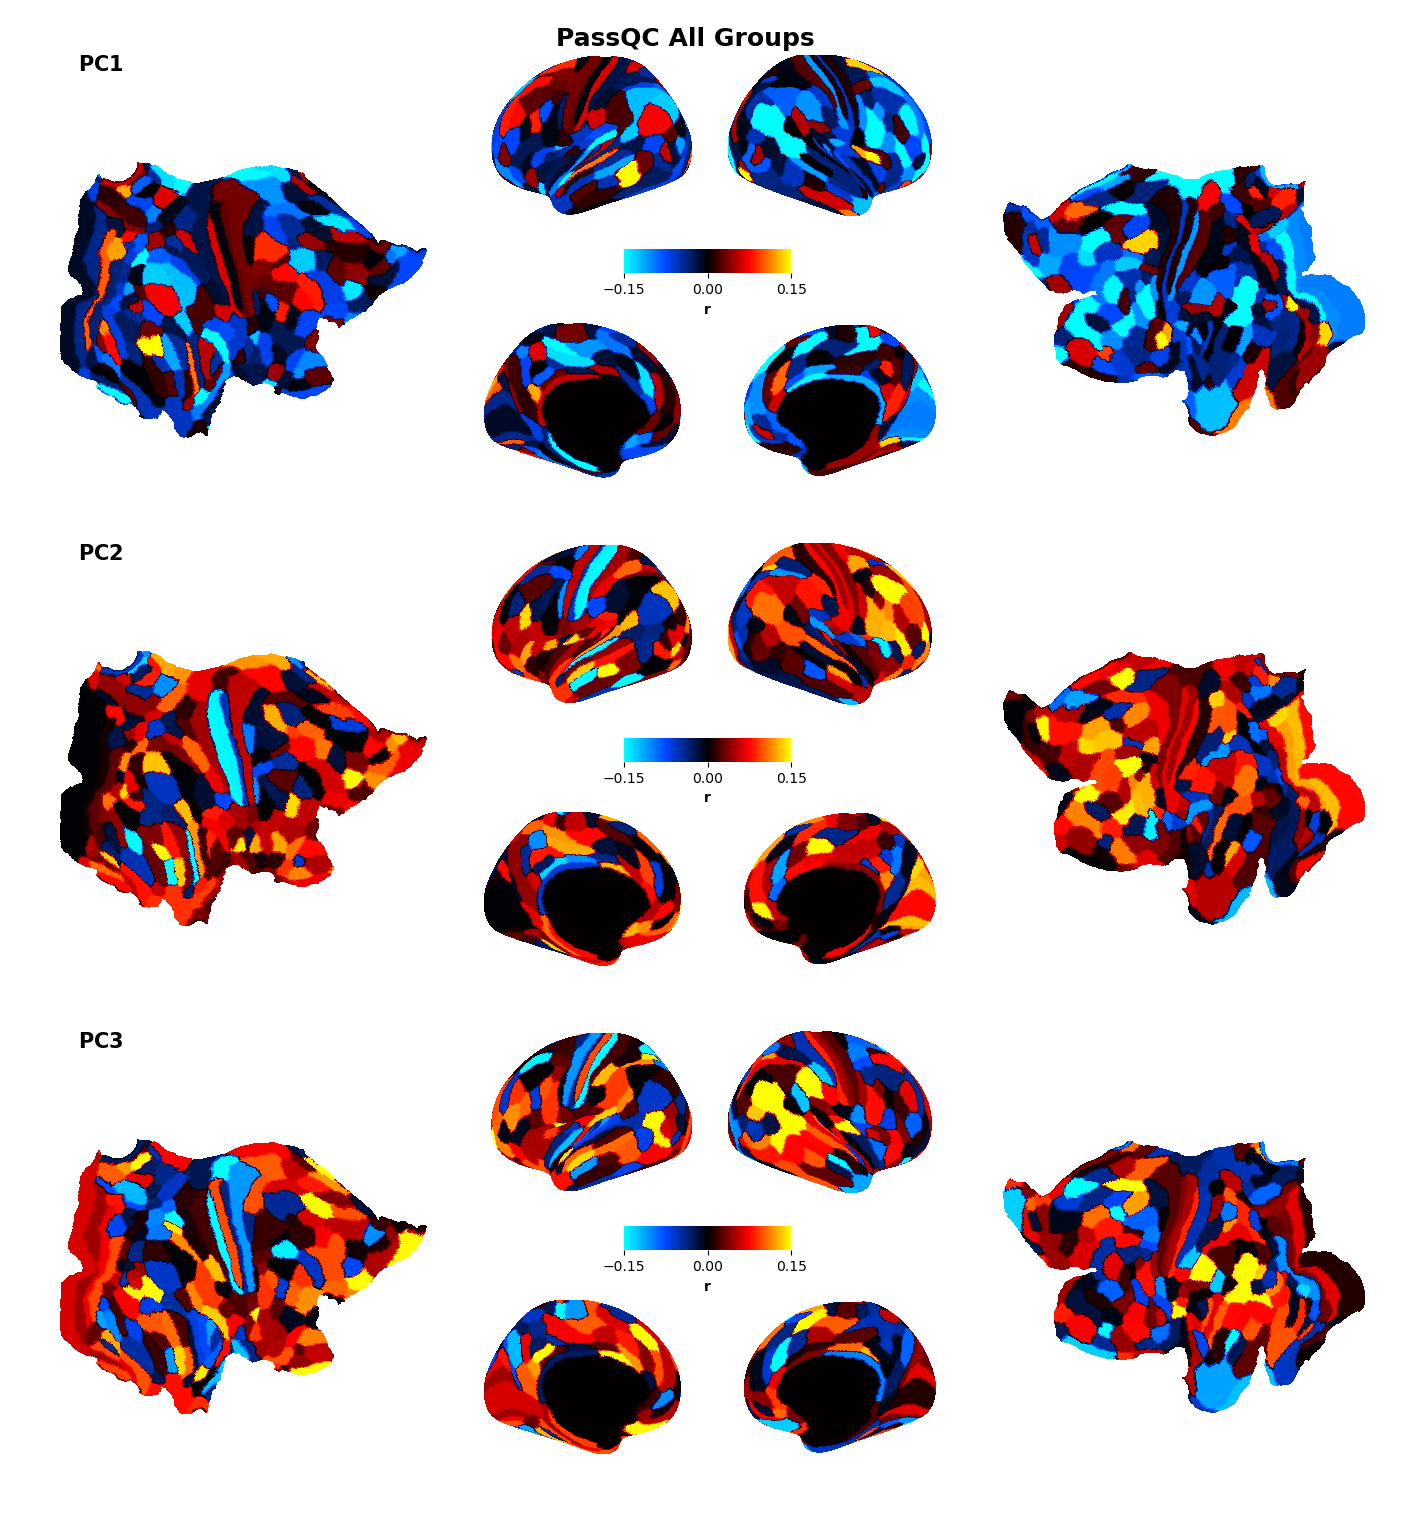

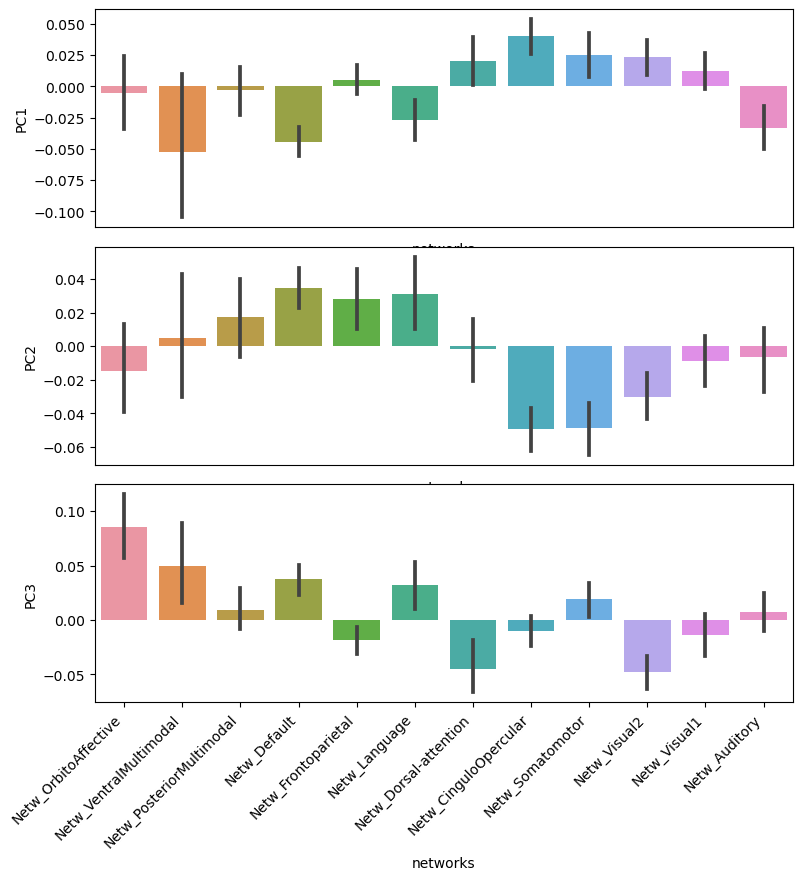

In [26]:
import os
import nibabel as nib
import nilearn.plotting as plotting
import hcp_utils as hcp
import matplotlib as mpl
import seaborn as sns


def neural_plots(mesh_file, neural_data, geom_data, title, subtitles, reverse=False):
    if type(neural_data) != list:
        neural_data = [neural_data]
    num_files = len(neural_data)
    fig = plt.figure(figsize=(18,num_files*9))
    #heights = [1,0.75,0.4,0.8]
    widths = [0.9,0.9,1,1,0.9,0.9]
    spec = fig.add_gridspec(ncols=6,nrows=num_files*2, width_ratios=widths)
    #spec = fig.add_gridspec(ncols=5,nrows=4,height_ratios=heights)
    fig.subplots_adjust(wspace=-0.04, hspace=-0.74, top=0.85, bottom=0.05)
    fig.suptitle(title, size=18, weight='bold', y=(0.41+(num_files*0.05)))
    # 0.57
    fig_geom = plt.figure(figsize=(9,num_files*3))
    spec_geom = fig_geom.add_gridspec(ncols=6,nrows=num_files*2)

    mesh = hcp.load_surfaces(example_filename=mesh_file)


    row=0
    for neural_file, geom_file, subtitle in zip(neural_data, geom_data, subtitles):
        #all possible views
        #vDict = {'lateral':0,'medial':1,'anterior':2,'posterior':3,'dorsal':4,'ventral':5}
        vDict = {'lateral':0,'medial':1}


        img = nib.load(neural_file)
        n_data = img.get_fdata()
        if reverse:
            n_data = n_data * -1

        vmin=-0.15
        vmax=0.15
        c256=["#00ffff","#00fdff","#00faff","#00f7ff","#00f4ff","#00f1ff","#00eeff","#00ebff","#00e9ff","#00e6ff","#00e3ff","#00e0ff","#00ddff","#00daff","#00d7ff","#00d4ff","#00d1ff","#00ceff","#00cbff","#00c9ff","#00c6ff","#00c3ff","#00c0ff","#00bdff","#00baff","#00b7ff","#00b4ff","#00b1ff","#00aeff","#00abff","#00a9ff","#00a6ff","#00a3ff","#00a0ff","#009dff","#009aff","#0097ff","#0094ff","#0091ff","#008eff","#008bff","#0088ff","#0086ff","#0083ff","#0080ff","#007dff","#007aff","#0077ff","#0074ff","#0071ff","#006eff","#006bff","#0069ff","#0066ff","#0063ff","#0060ff","#005dff","#005aff","#0057ff","#0054ff","#0051ff","#004eff","#004bff","#0048ff","#0046ff","#0045fb","#0044f7","#0043f3","#0042ef","#0041eb","#003fe7","#003ee3","#003ddf","#003cdb","#003bd7","#003ad3","#0039cf","#0038cb","#0037c7","#0035c3","#0034bf","#0033bb","#0032b7","#0031b3","#0030af","#002fab","#002ea7","#002da2","#002c9e","#002a9a","#002996","#002892","#00278e","#00268a","#002586","#002482","#00237e","#00227a","#002176","#001f72","#001e6e","#001d6a","#001c66","#001b62","#001a5e","#00195a","#001856","#001752","#00164e","#00144a","#001346","#001242","#00113e","#00103a","#000f36","#000e32","#000d2e","#000c2a","#000a26","#000922","#00081e","#00071a","#000616","#000512","#00040e","#00030a","#000206","#000102","#020000","#060000","#0a0000","#0e0000","#120000","#160000","#1a0000","#1e0000","#220000","#260000","#2a0000","#2e0000","#320000","#360000","#3a0000","#3e0000","#420000","#460000","#4a0000","#4e0000","#520000","#560000","#5a0000","#5e0000","#620000","#660000","#6a0000","#6e0000","#720000","#760000","#7a0000","#7e0000","#820000","#860000","#8a0000","#8e0000","#920000","#960000","#9a0000","#9e0000","#a20000","#a70000","#ab0000","#af0000","#b30000","#b70000","#bb0000","#bf0000","#c30000","#c70000","#cb0000","#cf0000","#d30000","#d70000","#db0000","#df0000","#e30000","#e70000","#eb0000","#ef0000","#f30000","#f70000","#fb0000","#ff0000","#ff0300","#ff0700","#ff0b00","#ff0f00","#ff1300","#ff1700","#ff1b00","#ff1f00","#ff2300","#ff2700","#ff2b00","#ff2f00","#ff3300","#ff3700","#ff3b00","#ff3f00","#ff4300","#ff4700","#ff4b00","#ff4f00","#ff5300","#ff5700","#ff5b00","#ff5f00","#ff6300","#ff6700","#ff6b00","#ff6f00","#ff7300","#ff7700","#ff7b00","#ff7f00","#ff8300","#ff8700","#ff8b00","#ff8f00","#ff9300","#ff9700","#ff9b00","#ff9f00","#ffa300","#ffa800","#ffac00","#ffb000","#ffb400","#ffb800","#ffbc00","#ffc000","#ffc400","#ffc800","#ffcc00","#ffd000","#ffd400","#ffd800","#ffdc00","#ffe000","#ffe400","#ffe800","#ffec00","#fff000","#fff400","#fff800","#fffc00","#ffff00"]
        cmap = mpl.colors.ListedColormap(c256)

        if '.pscalar.nii' in neural_file:
            plot_data = hcp.unparcellate(n_data[0], hcp.ca_parcels)
        else:
            plot_data = n_data

        c_data_left = hcp.left_cortex_data(plot_data)
        c_data_right = hcp.right_cortex_data(plot_data)

        axes = []
        for view in vDict.keys():
            ax_left = fig.add_subplot(spec[row+vDict[view],2], projection='3d')
            ax_right = fig.add_subplot(spec[row+vDict[view],3], projection='3d')
            axes.append(ax_left)
            axes.append(ax_right)
            
            

            plotting.plot_surf(mesh.very_inflated_left, surf_map=c_data_left, engine='matplotlib',view=view, figure=fig, 
                            axes=ax_left, hemi='left', vmin=vmin, vmax=vmax, cmap=cmap)
            #ax_left.view_init(azim=180)
            
            plotting.plot_surf(mesh.very_inflated_right, c_data_right, engine='matplotlib',view=view, figure=fig, 
                            axes=ax_right, hemi='right', vmin=vmin, vmax=vmax, cmap=cmap)
            
            #ax_left.set_facecolor('black')
            #ax_right.set_facecolor('black')

        ax_flat_left = fig.add_subplot(spec[row+0:row+2,0:2], projection='3d')
        ax_flat_right = fig.add_subplot(spec[row+0:row+2,4:6], projection='3d')
        axes.append(ax_flat_left)
        axes.append(ax_flat_right)
        plotting.plot_surf(mesh.flat_left, surf_map=c_data_left, engine='matplotlib', figure=fig, 
                            axes=ax_flat_left, hemi='left', vmin=vmin, vmax=vmax, cmap=cmap)
        plotting.plot_surf(mesh.flat_right, surf_map=c_data_right, engine='matplotlib', figure=fig, 
                            axes=ax_flat_right, hemi='left', vmin=vmin, vmax=vmax, cmap=cmap)

        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, shrink=0.12, aspect=7, pad=-0.24, orientation='horizontal',
                    ticks=[-0.15,0,0.15], label=fr"$\bf{{r}}$", drawedges=False)
        
        cb.outline.set_visible(False)

        ax_flat_left.set_title(subtitle, size=15, x=0.2)

        ax_geom = fig_geom.add_subplot(spec_geom[row:row+2,:])
        geom_df = pd.read_csv(geom_file)
        order_geom = ["Netw_OrbitoAffective", "Netw_VentralMultimodal", "Netw_PosteriorMultimodal", "Netw_Default", "Netw_Frontoparietal", "Netw_Language", "Netw_Dorsal-attention", "Netw_CinguloOpercular", "Netw_Somatomotor", "Netw_Visual2", "Netw_Visual1", "Netw_Auditory"]
        sns.barplot(data=geom_df, x='networks', y=geom_df.columns[0], order=order_geom, ax=ax_geom)
        if row == ((num_files-1)*2):
            ax_geom.set_xticks(ax_geom.get_xticks(), ax_geom.get_xticklabels(), rotation=45, ha='right')
        else:
            ax_geom.set(xticklabels=[])
            ax_geom.tick_params(bottom=False)
        
        
        row+=2
    fig_geom.savefig(f'{title.replace(" ","_")}_geometry.png')
    #fig.show()
    plt.show()
#template_path = '/Users/sab322/glasgow/neural/scenes/cifti_templates/HCPAtlas/HCP_Q1-Q6_GroupAvg_Related440_Unrelated100_v1/Q1-Q6_R440.L.very_inflated.32k_fs_LR.surf.gii'
mesh_data = '/Users/sab322/glasgow/neural/scenes/cifti_templates/HCPAtlas/HCP_Q1-Q6_GroupAvg_Related440_Unrelated100_v1/Q1-Q6_R440.L.very_inflated.32k_fs_LR.surf.gii'
data_format = '/Users/sab322/glasgow/neural/scenes/analysis/results/NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_initialize_BehaviorNeural_UnivariateMapping_Neural_ALL1.pscalar.nii'
pcs = 3
group = 'ALL'
neural_data = []
geom_data = []
subtitles = []
for pc in range(pcs):
    neural_data.append(f'/Users/sab322/glasgow/neural/scenes/analysis/results/NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_initialize_BehaviorNeural_UnivariateMapping_Neural_{group}{pc+1}.pscalar.nii')
    subtitles.append(fr'$\bf{{PC{pc+1}}}$')
    geom_data.append(f'/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_PassQC_CBS_NT_n176/analysis/results/geometry/PC{pc+1}_network_NT_n176_{group}.csv')
neural_plots(mesh_data, neural_data, geom_data, 'PassQC All Groups', subtitles, True)

Cannot load file /Users/sab322/glasgow/neural/scenes/cifti_templates/HCPAtlas/HCP_Q1-Q6_GroupAvg_Related440_Unrelated100_v1/Q1-Q6_R440.sulc.32k_fs_LR.dscalar.nii with sulcal depth data


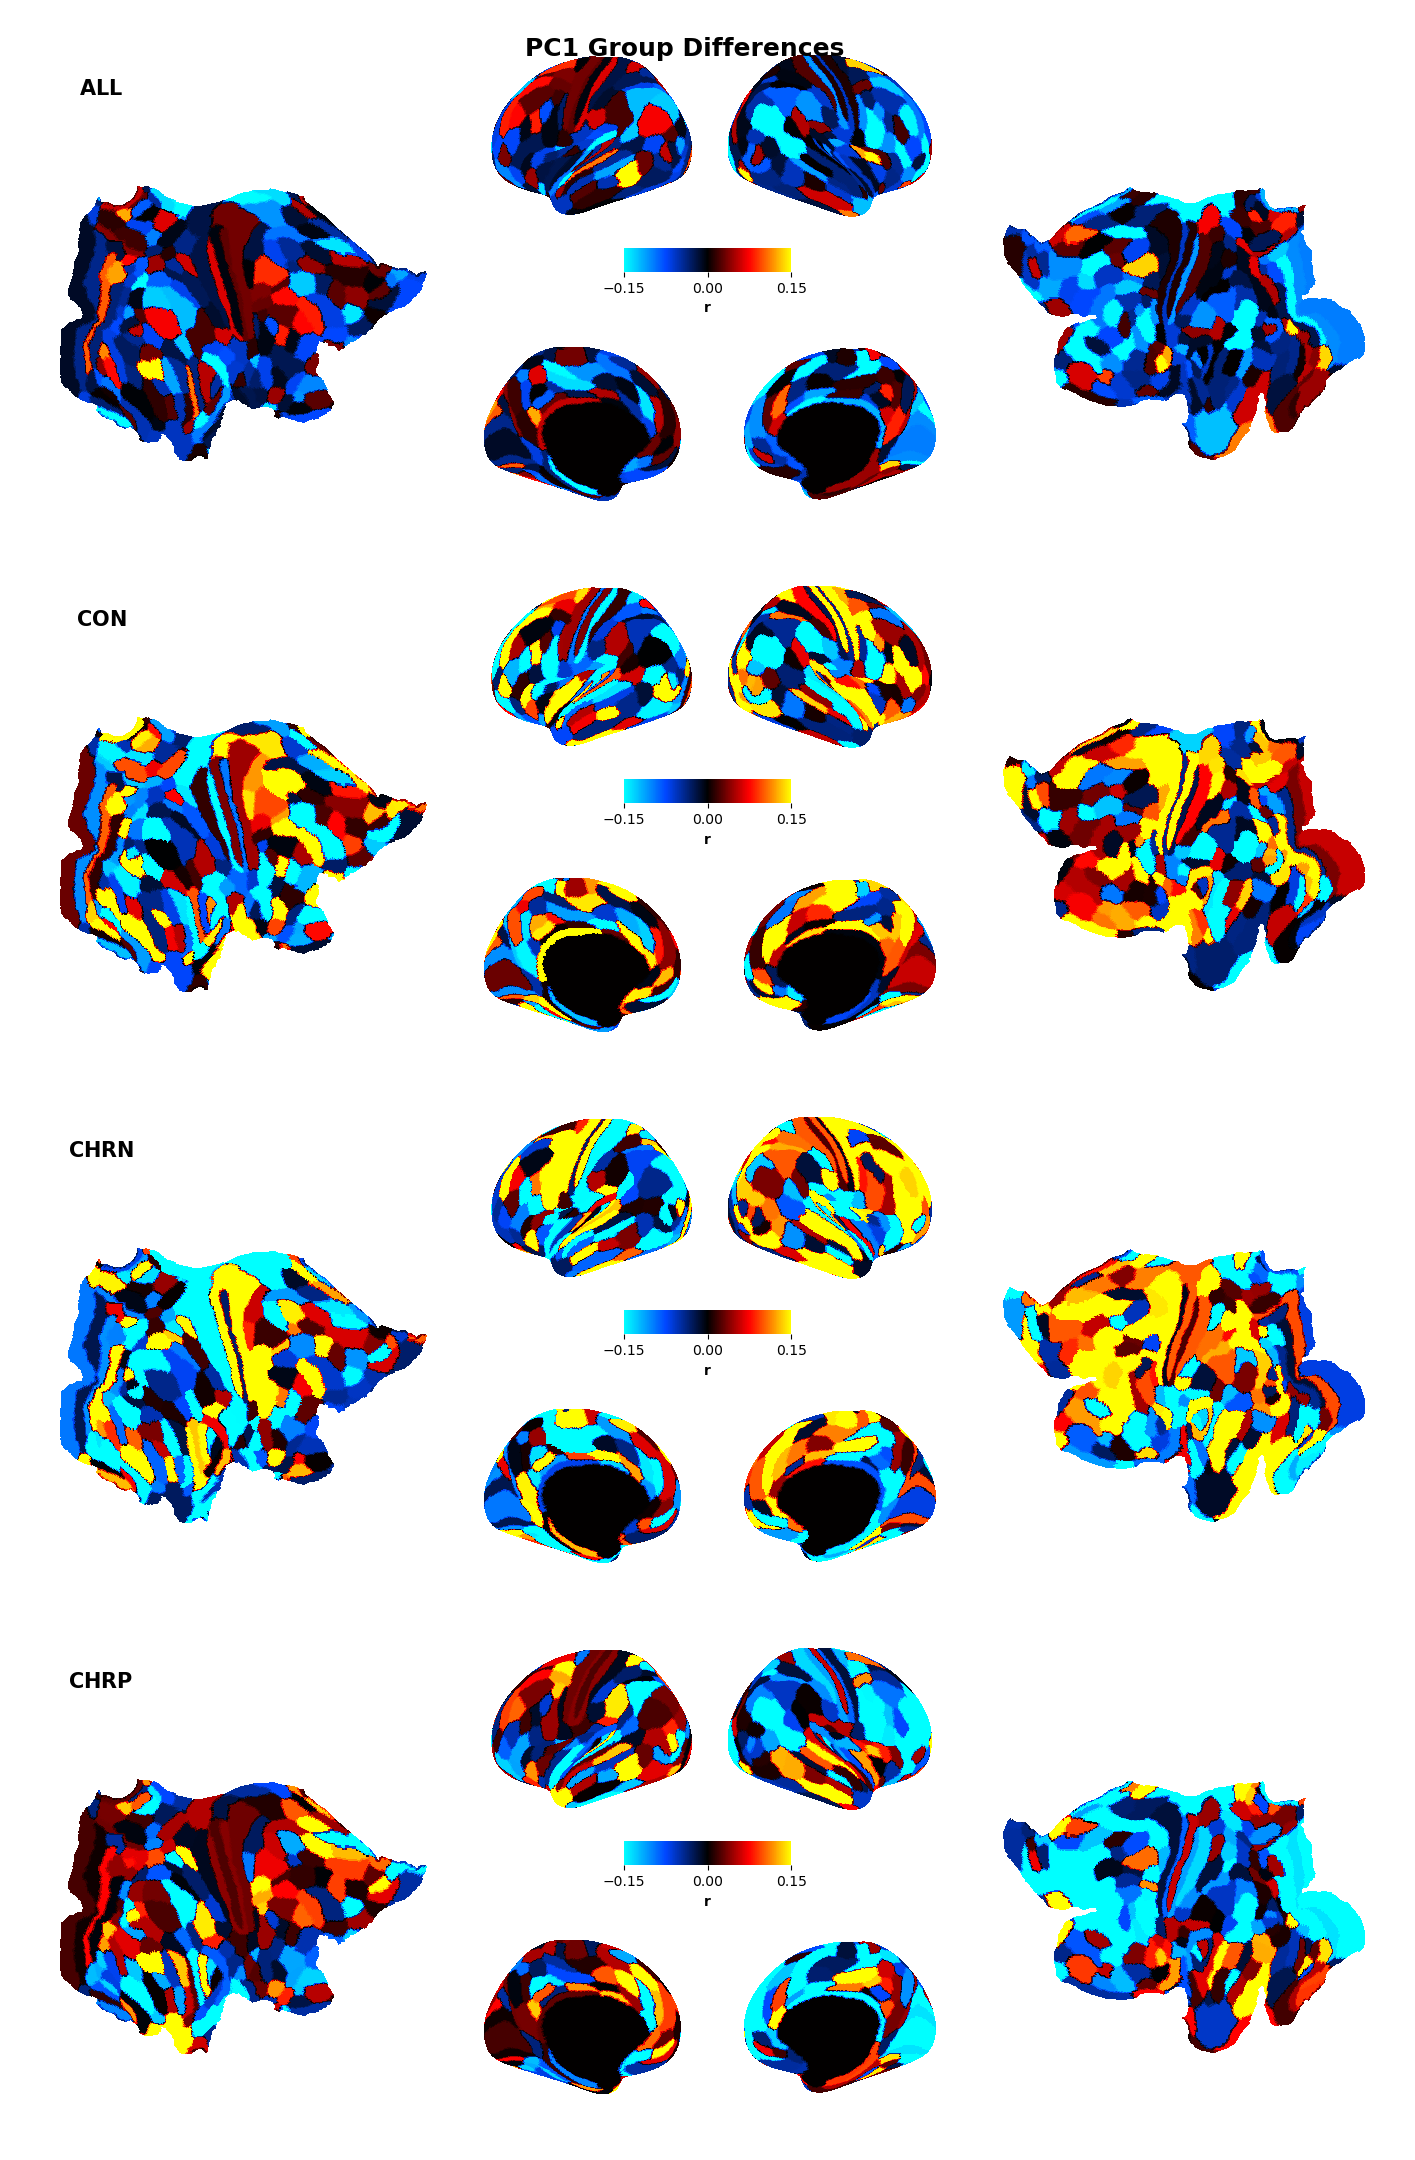

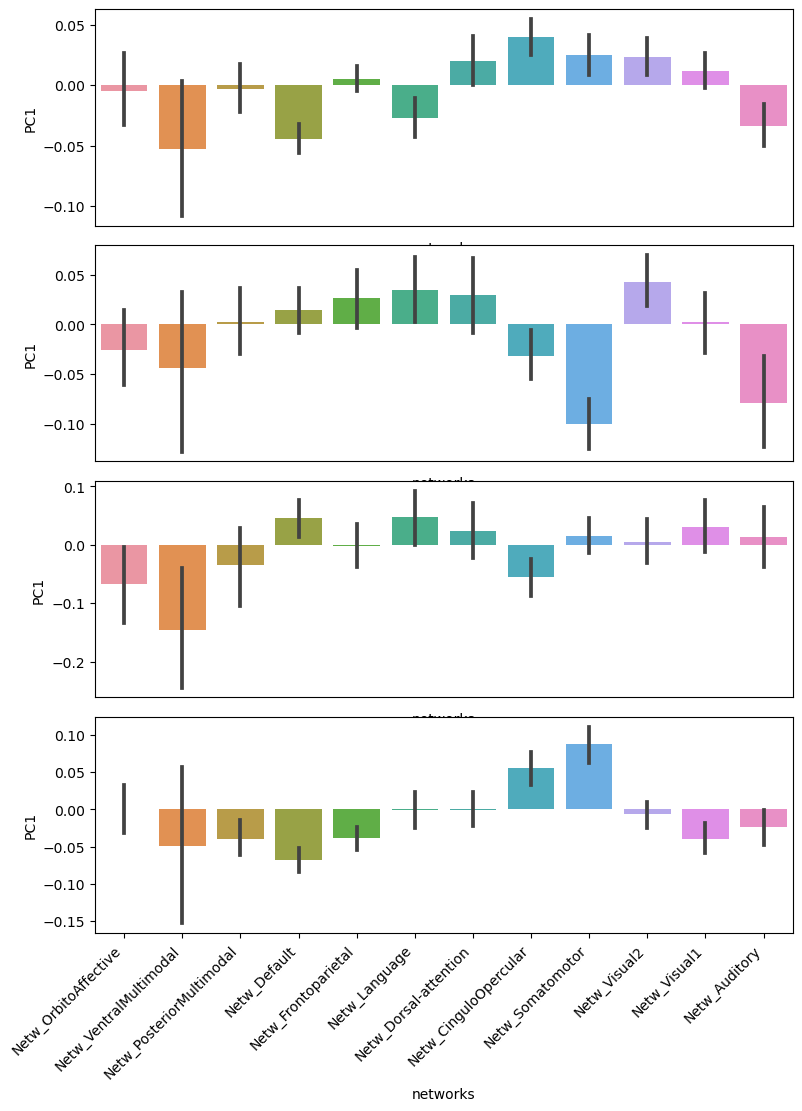

In [103]:
mesh_data = '/Users/sab322/glasgow/neural/scenes/cifti_templates/HCPAtlas/HCP_Q1-Q6_GroupAvg_Related440_Unrelated100_v1/Q1-Q6_R440.L.very_inflated.32k_fs_LR.surf.gii'
#data_format = '/Users/sab322/glasgow/neural/scenes/analysis/results/NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_initialize_BehaviorNeural_UnivariateMapping_Neural_ALL1.pscalar.nii'
pcs = 3
groups = ['ALL','CON','CHRN','CHRP']
neural_data = []
geom_data = []
subtitles = []
for group in groups:
    neural_data.append(f'/Users/sab322/glasgow/neural/scenes/analysis/results/NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_initialize_BehaviorNeural_UnivariateMapping_Neural_{group}1.pscalar.nii')
    subtitles.append(fr'$\bf{{{group}}}$')
    geom_data.append(f'/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_PassQC_CBS_NT_n176/analysis/results/geometry/PC1_network_NT_n176_{group}.csv')
neural_plots(mesh_data, neural_data, geom_data, 'PC1 Group Differences', subtitles, True)

In [ ]:
mesh_data = '/Users/sab322/glasgow/neural/scenes/cifti_templates/HCPAtlas/HCP_Q1-Q6_GroupAvg_Related440_Unrelated100_v1/Q1-Q6_R440.L.very_inflated.32k_fs_LR.surf.gii'
#data_format = '/Users/sab322/glasgow/neural/scenes/analysis/results/NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_initialize_BehaviorNeural_UnivariateMapping_Neural_ALL1.pscalar.nii'
pcs = 3
groups = ['ALL','CON','CHRN','CHRP']
neural_data = []
geom_data = []
subtitles = []
for group in groups:
    neural_data.append(f'/Users/sab322/glasgow/neural/scenes/analysis/results/NBRIDGE_Glasgow.collaboration_PassQC_CBS_NT_n176_initialize_BehaviorNeural_UnivariateMapping_Neural_{group}1.pscalar.nii')
    subtitles.append(fr'$\bf{{{group}}}$')
    geom_data.append(f'/Users/sab322/glasgow/presentation/data/Glasgow.collaboration_PassQC_CBS_NT_n176/analysis/results/geometry/PC1_network_NT_n176_{group}.csv')
neural_plots(mesh_data, neural_data, geom_data, 'PC1 Group Differences', subtitles, True)

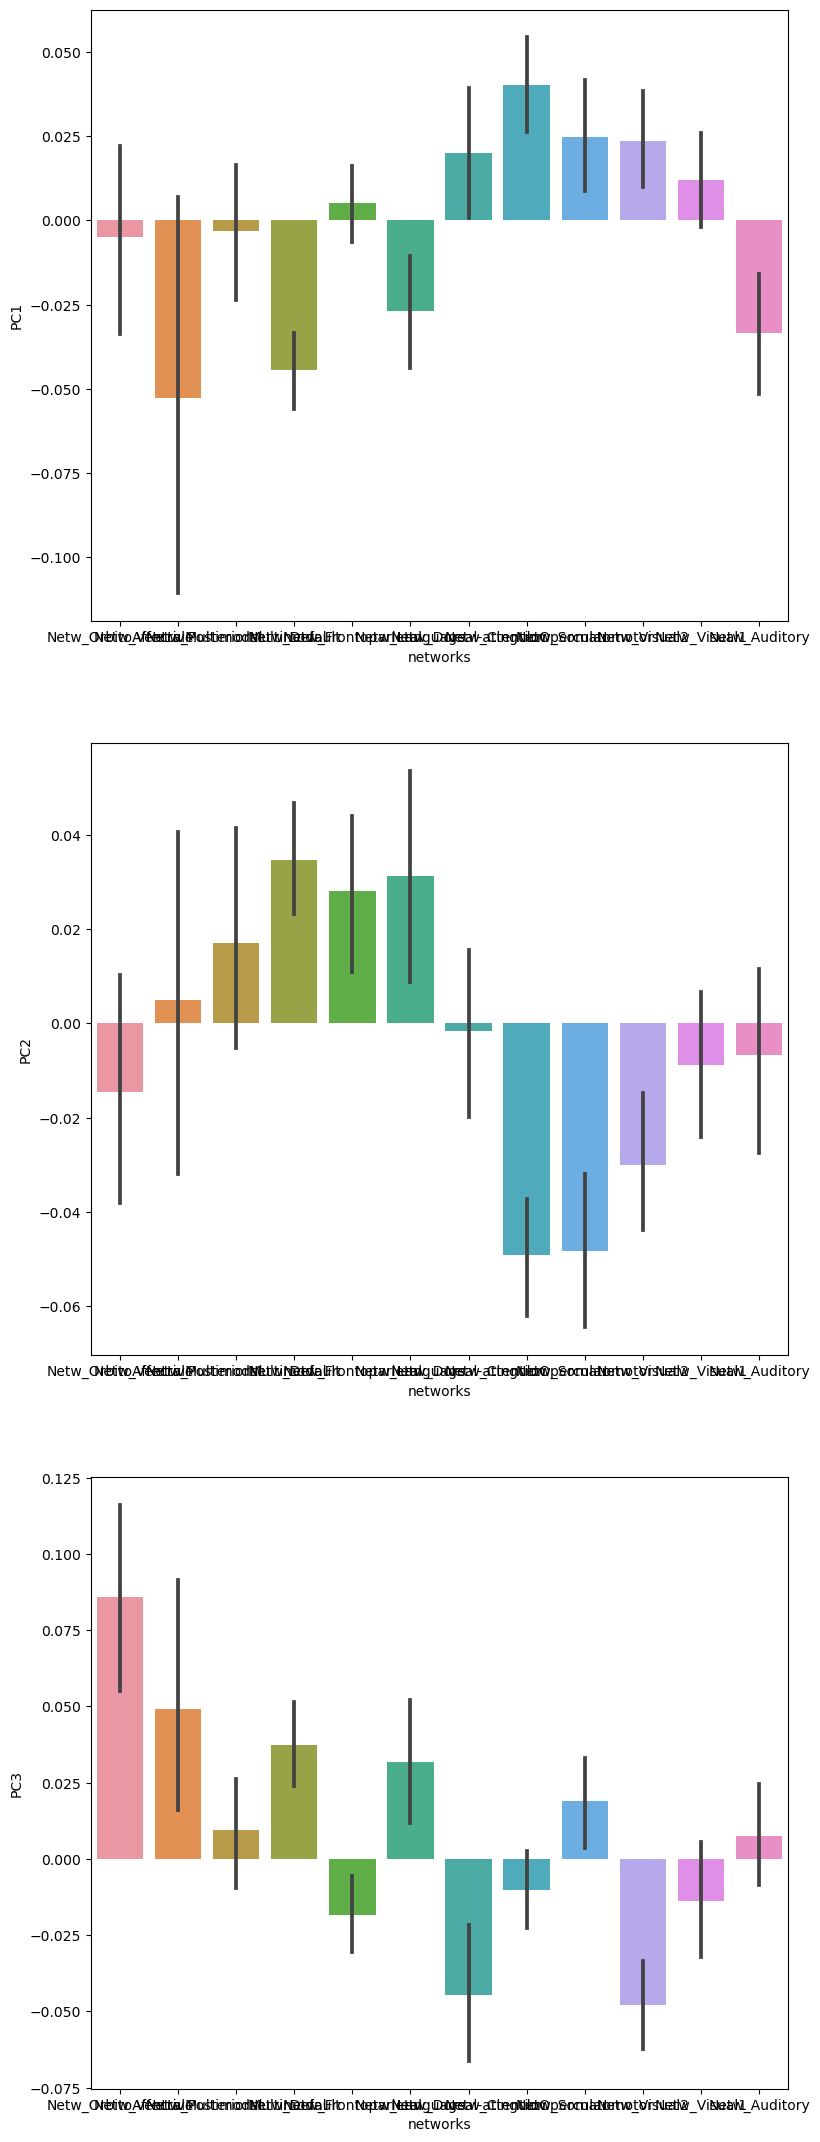

In [89]:
num_files=3
fig_geom = plt.figure(figsize=(9,num_files*9))
spec_geom = fig_geom.add_gridspec(ncols=2,nrows=3)
row=0
for geom_file in geom_data:
    ax_geom = fig_geom.add_subplot(spec_geom[row,0:2])
    geom_df = pd.read_csv(geom_file)
    order_geom = ["Netw_OrbitoAffective", "Netw_VentralMultimodal", "Netw_PosteriorMultimodal", "Netw_Default", "Netw_Frontoparietal", "Netw_Language", "Netw_Dorsal-attention", "Netw_CinguloOpercular", "Netw_Somatomotor", "Netw_Visual2", "Netw_Visual1", "Netw_Auditory"]
    sns.barplot(data=geom_df, x='networks', y=geom_df.columns[0], order=order_geom, ax=ax_geom)
    row+=1

In [315]:
def build_nbridge(csv_dir, out_dir, to_drop, name, followup=False):

    #Scan id's
    scans = pd.read_csv(f'{csv_dir}/Scan_Misc.csv')


    #CAARMS
    caarms = pd.read_csv(f'{csv_dir}/CAARMS_baseline.csv')

    #Get only relevant cols
    cols = []
    for col in caarms.columns.to_list():
        if 'final' in col:
            if 'distress' not in col:
                cols.append(col)


    caarms = caarms[['Study_ID'] + cols]
    caarms = caarms.drop(columns=['CAARMS_group_baseline_final_score'])

    caarms = caarms.replace('Not applicable',pd.NA)
    caarms = caarms.replace("-9999",pd.NA)
    caarms = caarms.replace(-9999.0,pd.NA)
    caarms = caarms.replace(" ",pd.NA)

    #Export rows with NA vals
    caarmsNA = caarms[caarms.isna().any(axis=1)]
    caarmsNA.to_csv(f"{csv_dir}/CAARMS_baseline_NA.csv", index=False)

    caarms = caarms.dropna()
    caarms['CAARMS_UTC_severity'] = caarms['CAARMS_UTC_global_baseline_final_score'] * caarms['CAARMS_UTC_frequency_baseline_final_score']
    caarms['CAARMS_NBI_severity'] = caarms['CAARMS_NBI_global_baseline_final_score'] * caarms['CAARMS_NBI_frequency_baseline_final_score']
    caarms['CAARMS_PA_severity'] = caarms['CAARMS_PA_global_baseline_final_score'] * caarms['CAARMS_PA_frequency_baseline_final_score']
    caarms['CAARMS_DS_severity'] = caarms['CAARMS_DS_global_baseline_final_score'] * caarms['CAARMS_DS_frequency_baseline_final_score']
    caarms = caarms.drop(columns=['CAARMS_UTC_global_baseline_final_score','CAARMS_UTC_frequency_baseline_final_score','CAARMS_NBI_global_baseline_final_score','CAARMS_NBI_frequency_baseline_final_score','CAARMS_PA_global_baseline_final_score','CAARMS_PA_frequency_baseline_final_score','CAARMS_DS_global_baseline_final_score','CAARMS_DS_frequency_baseline_final_score'])
    caarms.to_csv(f"{csv_dir}/CAARMS_baseline_final.csv", index=False)

    #BACS
    bacs = pd.read_csv(f'{csv_dir}/BACS_baseline.csv')
    bacs = bacs.replace('Not applicable',pd.NA)
    bacs = bacs.replace("-9999",pd.NA)
    bacs = bacs.replace(-9999.0,pd.NA)
    bacs = bacs.replace(" ",pd.NA)

    #bacs = scans.join(bacs.set_index('Study_ID'), on='Study_ID')

    #Export rows with NA vals
    bacs = bacs[['Study_ID'] + ["BACS_baseline_VerbMemory_total_score","BACS_baseline_DigitSeq","BACS_baseline_Tokens_correctly_in_container","BACS_baseline_SematicFluency","BACS_baseline_LetterFluency_F","BACS_baseline_LetterFluency_S","BACS_baseline_SymbolCoding","BACS_baseline_ToL"]]
    bacsNA = bacs[bacs.isna().any(axis=1)]
    bacsNA.to_csv(f"{csv_dir}/BACS_baseline_NA.csv", index=False)

    #bacs = bacs.dropna()
    bacs = bacs.dropna(thresh=len(bacs.columns)-2, axis=0)
    bacs = bacs.replace(pd.NA,"NA")
    bacs.to_csv(f"{csv_dir}/BACS_baseline_final.csv", index=False)

    #SPIA
    spia = pd.read_csv(f'{csv_dir}/SPIA_Baseline.csv')
    spia = spia.replace('Not applicable',pd.NA)
    spia = spia.replace("-9999",pd.NA)
    spia = spia.replace(-9999.0,pd.NA)
    spia = spia.replace(" ",pd.NA)

    #Get only relevant cols
    vars = ['B1','C5','O3','O7','C2','C3','C4','D3','D4','O1','O2','O8']
    vars13 = ['D5','F2','F3','O4_1','O4_2','O4_3','O4_4','O4_5','O4_6','O4_7','O4_8','O4_9','O4_10']
    vars14 = ['F5','O5_1','O5_2']
    cols1 = []
    cols13 = []
    cols14 = []

    spia_cols = spia.columns.to_list()
    for var in vars:
            for col in spia_cols:
                if 'final' in col:
                    if 'Dist' not in col:
                        if var in col:
                            cols1.append(col)

    for col in spia.columns.to_list():
        for var in vars13:
            if 'final' in col:
                if 'Dist' not in col:
                    if var in col:
                        cols13.append(col)
        for var in vars14:
            if 'final' in col:
                if 'Dist' not in col:
                    if var in col:
                        cols14.append(col)

    spia = spia[['Study_ID'] + cols1 + cols13 + cols14]

    spiaNA = spia[spia.isna().any(axis=1)]

    #7,8,9 not really valid. Replacing with NA
    spia = spia.replace(7.0, pd.NA)
    spia = spia.replace(8.0, pd.NA)
    spia = spia.replace(9.0, pd.NA)

    spia['SPIA_Visual_Perception'] = spia[cols13].sum(axis=1)
    spia['SPIA_Acoustic_Perception'] = spia[cols14].sum(axis=1)
    spia = spia.drop(columns=cols13)
    spia = spia.drop(columns=cols14)
    spiaNA.to_csv(f"{csv_dir}/SPIA_baseline_NA.csv", index=False)

    #spia = spia.dropna(thresh=len(spia.columns)-2, axis=0)
    spia = spia.replace(pd.NA,"NA")
    # GF002 = spia[spia['Study_ID'] == "GF002"]
    # GF002['SPIA_Visual_Perception'] = "NA"
    #spia.loc['GF002','SPIA_Visual_Perception'] = 0
    spia['SPIA_Visual_Perception'] = spia['SPIA_Visual_Perception'].astype(object)
    spia = spia.set_index('Study_ID')
    spia.loc['GF002','SPIA_Visual_Perception'] = "NA"
    spia.to_csv(f"{csv_dir}/SPIA_baseline_final.csv", index=False)

    #IPANAS
    ipanas = pd.read_csv(f'{csv_dir}/IPANAS_baseline.csv')
    ipanas = ipanas[["Study_ID","IPANAS_Interested_baseline","IPANAS_Excited_baseline","IPANAS_Strong_baseline","IPANAS_Enthusiastic_baseline","IPANAS_Proud_baseline","IPANAS_Inspired_baseline","IPANAS_Determined_baseline","IPANAS_Attentive_baseline","IPANAS_Active_baseline","IPANAS_Alert_baseline","IPANAS_Distressed_baseline","IPANAS_Upset_baseline","IPANAS_Guilty_baseline","IPANAS_Scared_baseline","IPANAS_Hostile_baseline","IPANAS_Irritable_baseline","IPANAS_Ashamed_baseline","IPANAS_Nervous_baseline","IPANAS_Jittery_baseline","IPANAS_Afraid_baseline"]]
    ipanas = ipanas.replace('Not applicable',pd.NA)
    ipanas = ipanas.replace("-9999",pd.NA)
    ipanas = ipanas.replace(-9999.0,pd.NA)
    ipanas = ipanas.replace(" ",pd.NA)

    #ipanas = scans.join(ipanas.set_index('Study_ID'), on='Study_ID')

    #Export rows with NA vals
    ipanasNA = ipanas[ipanas.isna().any(axis=1)]
    ipanasNA.to_csv(f"{csv_dir}/IPANAS_baseline_NA.csv", index=False)

    ipanas = ipanas.dropna(thresh=len(ipanas.columns)-2, axis=0)
    ipanas = ipanas.replace(pd.NA,"NA")
    ipanas.to_csv(f"{csv_dir}/IPANAS_baseline_final.csv", index=False)

    #Creating merged df

    groups = pd.read_csv(f'{csv_dir}/Group_Misc.csv')
    merged = scans.join(groups.set_index('Study_ID'), on='Study_ID')

    merged["Group"] = merged["Group"].astype(str)
    merged.loc[merged["Group"] == "0.0", "Group"] = "Control"
    merged.loc[merged["Group"] == "1.0", "Group"] = "Clinical High Risk - Negative"
    merged.loc[merged["Group"] == "2.0", "Group"] = "Clinical High Risk - Positive"
    merged.loc[merged["Group"] == "3.0", "Group"] = "First Episode Psychosis"
    merged.loc[merged["Group"] == "4.0", "Group"] = "Transition to FEP"
    merged.loc[merged["Group"] == "5.0", "Group"] = "Transition to HR"

    merged["Converted"] = merged["Group"] == "Transition to FEP"
    merged.loc[merged["Converted"] == True, "Converted"] = 1
    merged.loc[merged["Converted"] == False, "Converted"] = 0

    merged = merged.join(bacs.set_index('Study_ID'), on='Study_ID')
    merged = merged.join(caarms.set_index('Study_ID'), on='Study_ID')

    if followup:
        #load follow-up data
        f_df = pd.read_csv('../data/caarms_followup_all_delta_more.tsv', sep='\t')
        f_data = f_df[f_df['date'] == '12months']
        f_subj = f_data['participant_id'].to_list()
        merged = merged[merged.Scan_ID.isin(f_subj)]
        f_data_comp = pd.DataFrame()
        f_data_comp['participant_id'] = f_data['participant_id']
        f_data_comp['CAARMS_Composite_Delta'] = f_data[['UTC_Delta', 'NBI_Delta', 'PA_Delta', 'DS_Delta']].sum(axis=1)
        f_data_comp['CAARMS_GAF_Delta'] = f_data['GAF_Delta']
        f_data_comp = f_data_comp.rename(columns={'participant_id':'Scan_ID'})
        #print(f_data)
        merged = merged.merge(f_data_comp, on='Scan_ID', how='left')

    merged = merged.join(spia, on='Study_ID')

    merged = merged[~merged.Scan_ID.isin(to_drop)]


    cbs = merged.dropna()
    cbs = cbs.rename(columns={'Scan_ID':'participant_id'})
    cbs = cbs.drop('Study_ID', axis=1)
    cbs.to_csv(f"{out_dir}/{name}_ALL.tsv", sep='\t', index=False)

    if followup:
        cbs_f = cbs.drop(['CAARMS_Composite_Delta','CAARMS_GAF_Delta'], axis=1)
        cbs_f.to_csv(f"{out_dir}/{name}_ALL_NoFVars.tsv", sep='\t', index=False)
        cbs_of = f_data[['participant_id', 'Group','GAF_Delta', 'UTC_Delta', 'NBI_Delta', 'PA_Delta', 'DS_Delta']]
        cbs_of.to_csv(f"{out_dir}/{name}_ALL_FVars.tsv", sep='\t', index=False)

    cbs_nt = cbs[(cbs['Group'] != 'Transition to FEP') & (cbs['Group'] != 'Transition to HR')]
    cbs_nt.to_csv(f"{out_dir}/{name}_NT.tsv", sep='\t', index=False)

    cbs_t = cbs[(cbs['Group'] == 'Transition to FEP') | (cbs['Group'] == 'Transition to HR')]
    cbs_t.to_csv(f"{out_dir}/{name}_T.tsv", sep='\t', index=False)

qc_fail = ["BKE11","CJY31","CTR13","FCS07","KBL14","MCA13","MMA21","MPA20","RSS08","SPA12","SWE24"]
build_nbridge("../csvs","../data", qc_fail, 'behavior_convert')
qc_fail = ["BKE11","CJY31","CTR13","FCS07","KBL14","MCA13","MMA21","MPA20","RSS08","SPA12","SWE24"]
build_nbridge("../csvs","../data", qc_fail, 'behavior_followup', True)

/var/folders/_f/51yc4jgj2yb300z_hgqpzxq59rm7sh/T/ipykernel_44117/2578905355.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  merged.loc[merged["Converted"] == True, "Converted"] = 1
/var/folders/_f/51yc4jgj2yb300z_hgqpzxq59rm7sh/T/ipykernel_44117/2578905355.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  merged.loc[merged["Converted"] == True, "Converted"] = 1


In [542]:
nb = pd.read_csv('../data/behavior_convert_ALL.tsv', sep='\t')
nb_c = nb[nb['Group'] == 'Control']
nb_nc = nb[nb['Group'] != 'Control']

nb_c.to_csv('../data/behavior_C_convert_ALL.tsv', sep='\t', index=False)
nb_nc.to_csv('../data/behavior_NC_convert_ALL.tsv', sep='\t', index=False)

convert = nb[['Converted']]
convert.to_csv('../data/converter_d.csv', header=False, index=False)

In [531]:
just_caarms = pd.read_csv('../data/behavior_baseline_CAARMS.tsv', sep='\t')
just_caarms

participant_id                          Group  Converted  \
0            BDA15  Clinical High Risk - Positive          0   
1            CMH10  Clinical High Risk - Positive          0   
2            APS28              Transition to FEP          1   
3            JSA14  Clinical High Risk - Positive          0   
4            HSS25              Transition to FEP          1   
..             ...                            ...        ...   
187          LTE22  Clinical High Risk - Negative          0   
188          JBR31  Clinical High Risk - Negative          0   
189          CBA31  Clinical High Risk - Negative          0   
190          BWH17  Clinical High Risk - Negative          0   
191          GRO29  Clinical High Risk - Negative          0   

     CAARMS_GAF_Score_baseline_final_score  CAARMS_UTC_severity  \
0                                     69.0                  0.0   
1                                     58.0                 12.0   
2                                     52.0                  9.0   
3                                     63.0                 15.0   
4                                     60.0                 15.0   
..                                     ...                  ...   
187                                   58.0                  0.0   
188                                   63.0                  0.0   
189                                   80.0                  0.0   
190                                   78.0                  2.0   
191                                   78.0                  4.0   

     CAARMS_NBI_severity  CAARMS_PA_severity  CAARMS_DS_severity  
0                    8.0                 4.0                 8.0  
1                   15.0                15.0                12.0  
2                   20.0                 8.0                15.0  
3                    8.0                 3.0                 8.0  
4                   16.0                20.0                 0.0  
..                   ...                 ...                 ...  
187                  0.0                 0.0                 0.0  
188                  6.0                 0.0                 0.0  
189                  0.0                 0.0                 0.0  
190                  6.0                 6.0                10.0  
191                  0.0                 0.0                 0.0  

[192 rows x 8 columns]